In [1]:
!pip install pyspark
!pip install findspark

## Step 1: Descriptive/summative Analysis

### Importing necessary packages

In [4]:
#Import necessary packages
import findspark
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, count, when, mean
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.sql import SparkSession

In [5]:
#Create the spark session
findspark.init()
spark = SparkSession.builder.appName("StockAnalysis").getOrCreate()

In [6]:
#load data from the file
full_stock_df = spark.read.load("fh_5yrs.csv", format="csv", sep=",", header="true", inferSchema=True)

In [5]:
full_stock_df.show()

+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|257500|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|17.709999084472656|  AAAU|
|2020-07-01|468100|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-30|319100|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|17.780000686645508|  AAAU|
|2020-06-29|405500|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-26|335100|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|17.670000076293945|  AAAU|
|2020-06-25|246800|17.60

### Data Characterisation

In [6]:
#Check the missiing values

missing_values = full_stock_df.select([count(when(col(c).isNull(), c)).alias(c) for c in full_stock_df.columns]).toPandas()
print("Missing Values:")
print(missing_values)

Missing Values:
   date  volume  open  high  low  close  adjclose  symbol
0     0       0     0     0    0      0         0       0


According to the above result we can comfirm that, there are no any missing values present in this datset

In [7]:
# Check shape of data
print('number of rows:',(full_stock_df.count()))
print('number of columns:', len(full_stock_df.columns))

number of rows: 6852038
number of columns: 8


In [8]:
# Check data types of each feature
print("Data Types:")
full_stock_df.printSchema()

Data Types:
root
 |-- date: date (nullable = true)
 |-- volume: long (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)



#### Feature Description

1. Date: Represents the temporal aspect, indicating specific points in time.

2. Volume: Reflects the trading activity, representing the total number of shares traded during a specific period.

3. Open: Indicates the opening value of a stock, i.e., the initial price when trading begins.

4. High: Represents the highest value of a stock during a given trading day.

5. Low: Represents the lowest value of a stock during a given trading day.

6. Close: Reflects the closing value of a stock, i.e., the price at the end of the trading day.

7. Adjclose: Likely represents an adjusted closing value, accounting for corporate actions like dividends and stock splits.

8. Symbol: Identifies the stock associated with the financial data.

#### Feature Categorization:

* Temporal Features: Date
* Quantitative Features:
  * Continuous: Volume, Open, High, Low, Close, Adjclose
* Qualitative Features: Symbol

### Summary Statistics

In [9]:
# Get summary of statistics
print("Summary Statistics:")
summary_stats = full_stock_df.summary().toPandas()
print(summary_stats)

Summary Statistics:
  summary              volume                  open                high  \
0   count             6852038               6852038             6852038   
1    mean  1015413.7055740205     298.0861291125566  305.87568055661416   
2  stddev   4833379.770318005    115808.75604569932  118216.09193700922   
3     min                   1  0.001000000047497451                 0.0   
4     25%               18700    11.949999809265135  12.130000114440918   
5     50%              120600     24.95000076293945  25.114999771118164   
6     75%              586200      47.9000015258789  48.349998474121094   
7     max          2156725200           6.9155304E7         7.0588576E7   

                  low                 close            adjclose   symbol  
0             6852038               6852038             6852038  6852038  
1  291.01362003484275     296.7830805422865  293.23114568836405      NaN  
2  113528.60373529146    115157.54666986146  114344.26187778547      NaN  
3   

### Stocks of car companies

In [7]:
#Got the list of the top 20 car company symbols from the website (https://stockanalysis.com/list/car-company-stocks/)

# List of car company symbols
car_company_symbols = ["TSLA", "TM", "RACE", "BYDDF", "BMWYY", "MBGYY", "STLA", "VWAGY", "HMC", "VLVLY", "GM", "F", "LI", "HYMTF", "MAHMF", "GWLLY", "SZKMY", "RIVN", "VFS", "NSANY"]


### Filter & Selection of Data for Analysis

In [8]:
# Filter DataFrame for car company symbols
car_company_df = full_stock_df.filter(col('symbol').isin(car_company_symbols))

# Check entry counts for each car company symbol
car_company_entry_counts = car_company_df.groupBy('symbol').agg(count('*').alias('entry_count')).orderBy('entry_count', ascending=False)

# Display the result
car_company_entry_counts.show(truncate=False)

+------+-----------+
|symbol|entry_count|
+------+-----------+
|F     |1385       |
|GM    |1385       |
|HMC   |1385       |
|TSLA  |1385       |
|TM    |1385       |
|RACE  |1183       |
+------+-----------+



According to the above result, among the car company symbols provided, we identified 6 symbols in the dataset. The top 5 symbols with the highest entry counts, each having __1385__ entries, include __Ford (F), General Motors (GM), Honda (HMC), Tesla (TSLA), and Toyota (TM).__ These symbols will be the focus of our detailed analysis due to their substantial representation in the dataset.

In [9]:
# List of selected car companies
selected_car_companies = ["F", "GM", "HMC", "TSLA", "TM"]

# Filter DataFrame for selected car companies
selected_car_df = full_stock_df.filter(col('symbol').isin(selected_car_companies))

#Display the filtered DataFrame
selected_car_df.show()

+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|      date|   volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02| 67245800|6.0999999046325675| 6.170000076293945|               6.0| 6.050000190734862| 6.050000190734862|     F|
|2020-07-01| 62454700|6.0999999046325675| 6.179999828338622| 5.949999809265138| 5.980000019073486| 5.980000019073486|     F|
|2020-06-30| 61909300| 5.980000019073486|6.0999999046325675|5.9000000953674325| 6.079999923706055| 6.079999923706055|     F|
|2020-06-29| 58208400|5.9099998474121085| 6.070000171661378| 5.809999942779541| 6.010000228881836| 6.010000228881836|     F|
|2020-06-26|118435400| 6.039999961853027| 6.070000171661378| 5.809999942779541|5.9099998474121085|5.9099998474121085|     F|


## Descriptive Analysis

#### 1. Based on each selected symbols

In [13]:
from pyspark.sql.functions import col, mean, stddev, min, max


# Display summary statistics for each selected car company
for company in selected_car_companies:
    # Filter DataFrame for the current car company
    current_company_df = selected_car_df.filter(col('symbol') == company)
    
    # Calculate summary statistics
    current_company_summary_stats = current_company_df.describe()
    
    # Show the result
    print(f"Summary Statistics for {company}:")
    current_company_summary_stats.show(truncate=False)
    print("\n" + "="*50 + "\n")  # Separator line

Summary Statistics for F:
+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+------+
|summary|volume             |open              |high              |low               |close             |adjclose         |symbol|
+-------+-------------------+------------------+------------------+------------------+------------------+-----------------+------+
|count  |1385               |1385              |1385              |1385              |1385              |1385             |1385  |
|mean   |4.147695155234657E7|11.33958124305367 |11.444404330752818|11.214454893256782|11.328310476227358|9.70352403695833 |NULL  |
|stddev |2.395072249278749E7|2.5906967475207647|2.594117695865026 |2.5908120621751105|2.5961139256062333|1.583137744194479|NULL  |
|min    |7760600            |4.269999980926514 |4.420000076293945 |3.9600000381469727|4.010000228881837 |4.010000228881837|F     |
|max    |231800800          |16.579999923706055|16.739999

#### FINDINGS: 
Among selected car companies, Ford (F), General Motors (GM), Honda (HMC), Tesla (TSLA), and Toyota (TM), we observe notable differences in their stock opening prices. Tesla stands out with the highest mean opening price of approximately 310.46, reflecting the unique position of the electric vehicle manufacturer in the market. In contrast, Honda has a comparatively lower mean opening price of around 29.36. General Motors and Toyota fall in between, with mean opening prices of 34.99 and 123.04, respectively. The standard deviations highlight the volatility in Tesla's stock, while the other companies exhibit relatively lower volatility. Examining the range of opening prices, Tesla showcases a wide span, reaching up to 1,221.48, emphasizing the dynamic nature of its stock. These insights provide a snapshot of the diverse stock performances among the selected car companies, offering valuable information for investors and analysts.







#### 2. Based on each features

This summary statistics is generated to get the overall understanding of specific feature for all selected car company stocks in a single sight

In [15]:
from pyspark.sql.functions import col, mean, stddev, min, max
import pandas as pd

# Display summary statistics for each column according to each selected car company
for stat_name in ['mean', 'stddev', 'min', 'max']:
    print(f"Summary Statistics ({stat_name}) according to each stock:")
    
    # Create an empty DataFrame to store summary statistics
    summary_stats_df = pd.DataFrame(columns=['Company'] + selected_car_df.columns)
    
    # Calculate summary statistics for each stock
    for company in selected_car_companies:
        row = {'Company': company}
        
        # Calculate summary statistics for each column
        for column_name in selected_car_df.columns:
            if column_name != 'date':  # Exclude 'date' column
                # Filter DataFrame for the current car company
                current_company_df = selected_car_df.filter(col('symbol') == company)
                
                # Calculate the specified summary statistic for the current column
                current_column_stats = current_company_df.select(
                    eval(f'{stat_name}(col(column_name))').alias(stat_name)
                ).collect()[0]
                
                # Populate the row with summary statistic
                row[column_name] = current_column_stats[stat_name]
        
        # Append the row to the summary statistics DataFrame
        summary_stats_df = pd.concat([summary_stats_df, pd.DataFrame([row])], ignore_index=True)
    
    # Display the summary statistics DataFrame for the current statistic
    print(summary_stats_df)
    print("=" * 50 + "\n")  # Separator line

Summary Statistics (mean) according to each stock:
  Company date        volume        open        high         low       close  \
0       F  NaN  4.147695e+07   11.339581   11.444404   11.214455   11.328310   
1      GM  NaN  1.302174e+07   34.986845   35.337069   34.580412   34.956635   
2     HMC  NaN  7.073048e+05   29.363394   29.503069   29.192101   29.347884   
3    TSLA  NaN  7.618748e+06  310.458224  316.522621  304.331292  310.688672   
4      TM  NaN  2.487726e+05  123.039357  123.566087  122.416079  122.999415   

     adjclose symbol  
0    9.703524   None  
1   31.324055   None  
2   26.985082   None  
3  310.688672   None  
4  115.899773   None  

Summary Statistics (stddev) according to each stock:
  Company date        volume        open        high         low       close  \
0       F  NaN  2.395072e+07    2.590697    2.594118    2.590812    2.596114   
1      GM  NaN  6.270700e+06    4.632532    4.601194    4.681712    4.645607   
2     HMC  NaN  4.040848e+05    3.20

### Count Plots

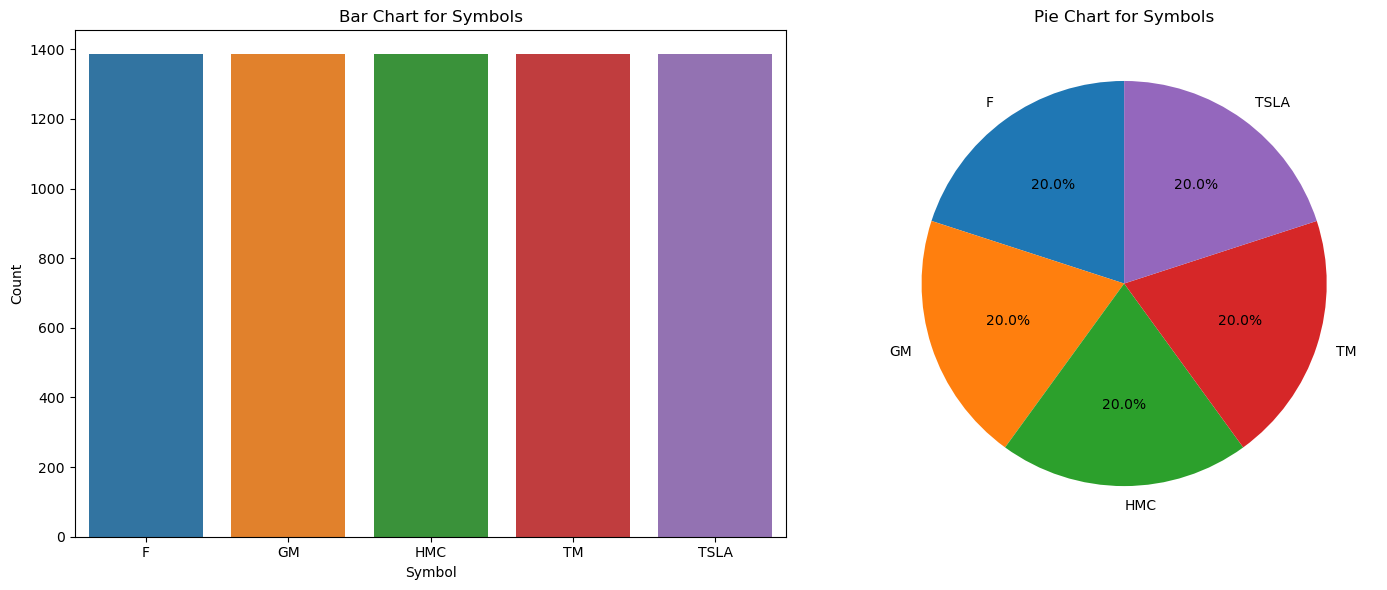

In [10]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_car_df.toPandas()

# Countplot for 'symbol'
plt.figure(figsize=(15, 6))

# Bar chart
plt.subplot(1, 2, 1)
sns.countplot(x='symbol', data=pandas_df, order=pandas_df['symbol'].value_counts().index)
plt.title('Bar Chart for Symbols')
plt.xlabel('Symbol')
plt.ylabel('Count')

# Pie chart
plt.subplot(1, 2, 2)
symbol_counts = pandas_df['symbol'].value_counts()
plt.pie(symbol_counts, labels=symbol_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart for Symbols')

plt.tight_layout()
plt.show()

Since symbol is the only categorical feature in the data set the count plot of it represented by a pie chart and a barchart above

### Distribution of numerical features

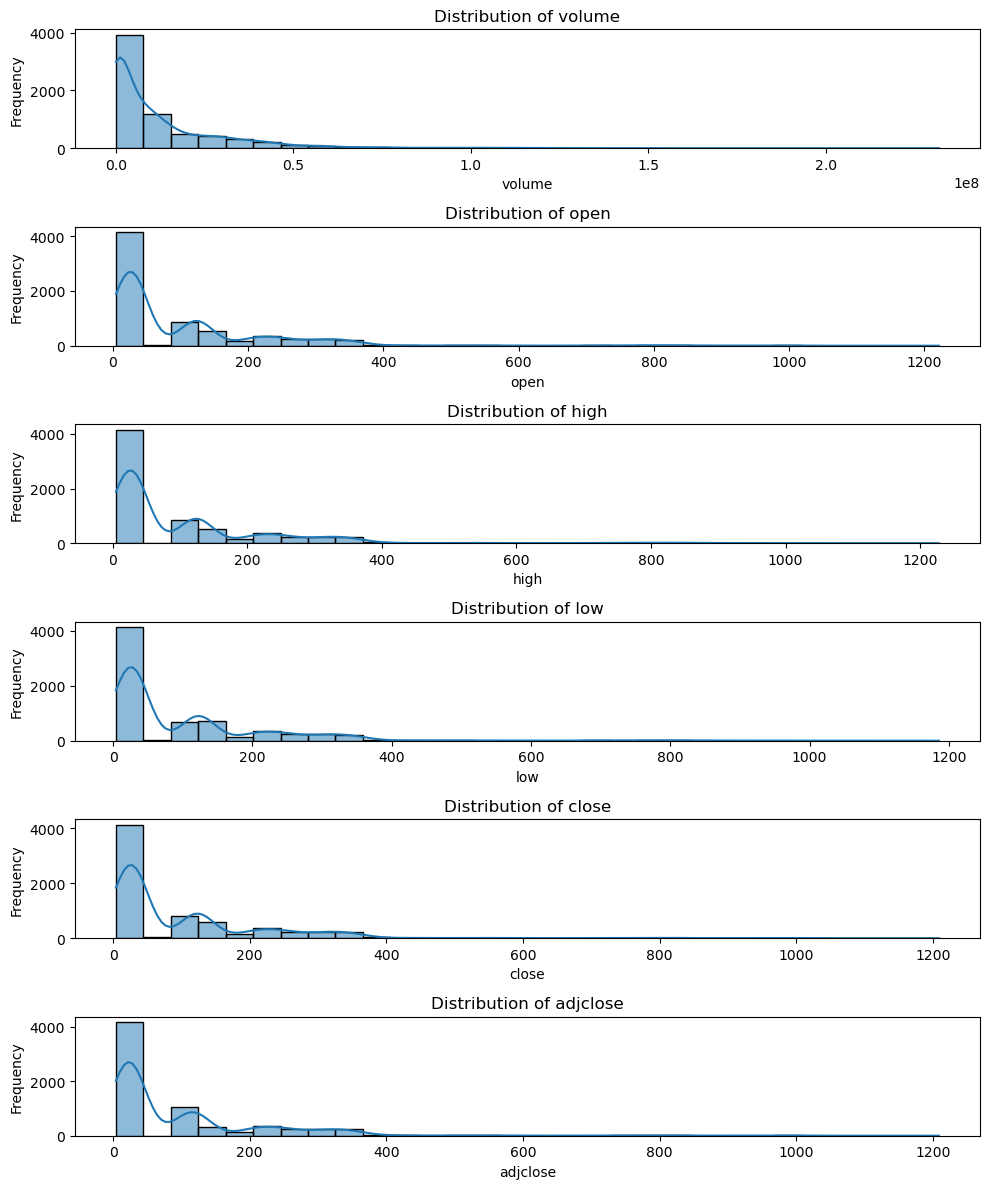

In [11]:
# Select numerical columns for distribution exploration
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 12))

# Plot histograms for each numerical feature
for i, column in enumerate(numerical_columns):
    sns.histplot(pandas_df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Scatter & Density Plot Matrix

C:\Users\94772\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


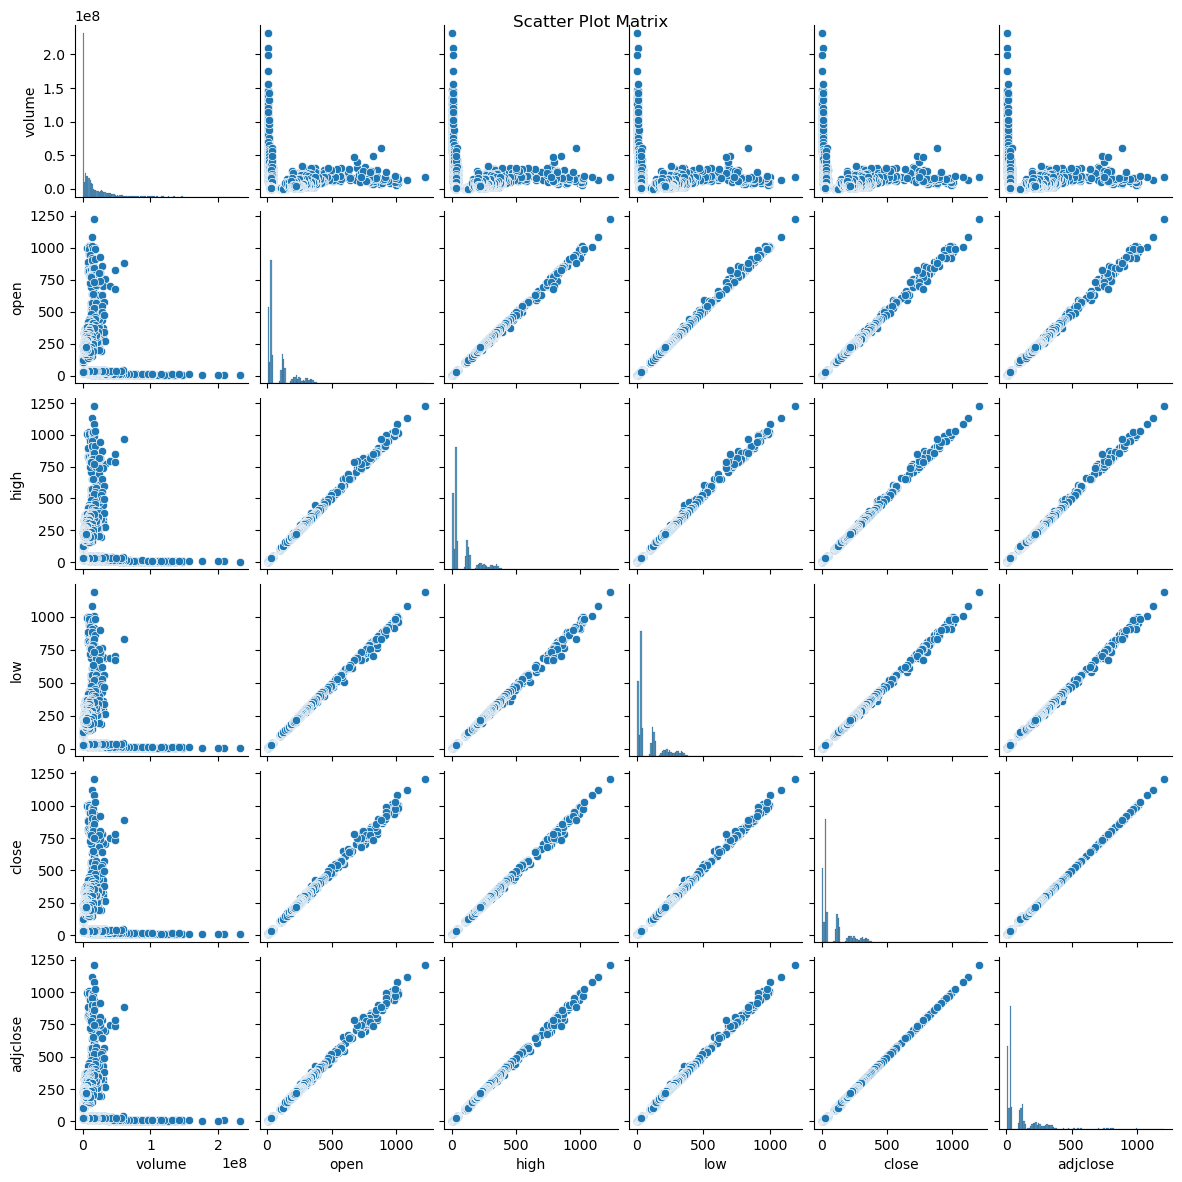

C:\Users\94772\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


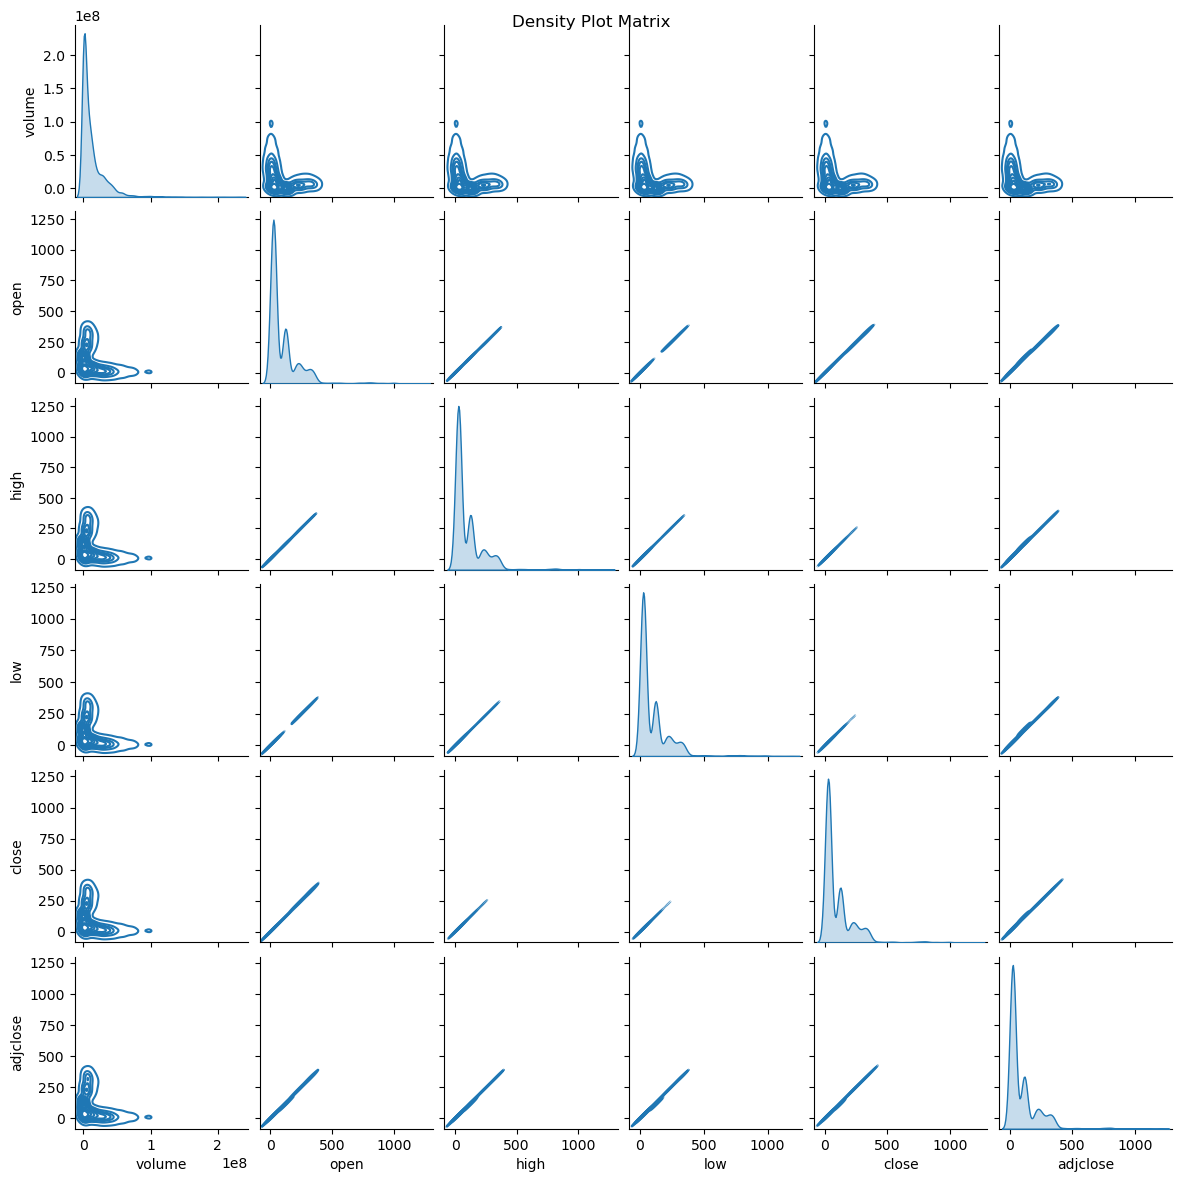

In [12]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_car_df.toPandas()

# Select numerical columns for the scatter plot matrix
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Create scatter plot matrix
scatter_matrix = sns.pairplot(pandas_df[numerical_columns], height=2)

# Display the scatter plot matrix
plt.suptitle('Scatter Plot Matrix')
plt.show()

# Create density plot matrix
density_matrix = sns.pairplot(pandas_df[numerical_columns], kind='kde', height=2)

# Display the density plot matrix
plt.suptitle('Density Plot Matrix')
plt.show()

__FINDINGS:__

Upon examining the scatter plot matrix, the diagonal patterns stand out, indicating strong positive correlations between open, high, low, close, and adjclose columns. The points in these scatter plots would align in a linear fashion, emphasizing the consistency in their positive relationships. 

In contrast, when exploring scatter plots involving trading volume and other price-related metrics, you would observe a dispersed or slightly downward trend. This scattering of points illustrates the identified negative correlations between volume and stock prices.

### Time Series Analysis

### 1. Close price

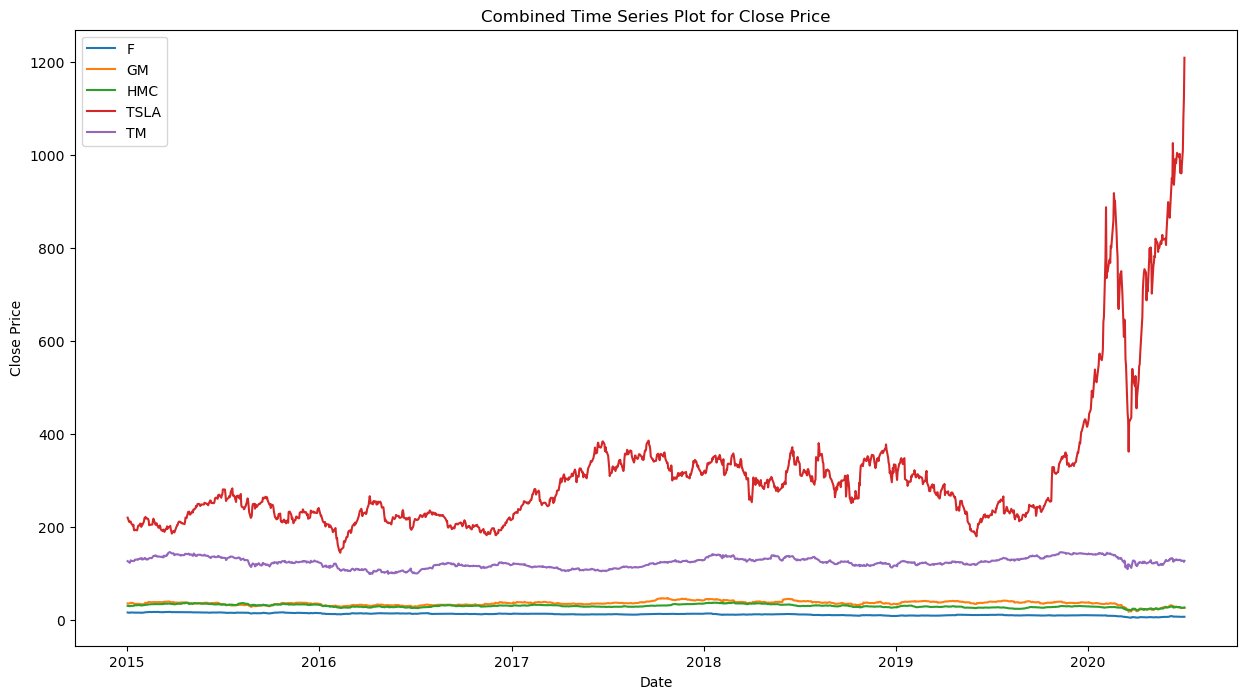

In [15]:
# Set up the plot
plt.figure(figsize=(15, 8))

# Plot time series for the closing rate for each symbol with different colors
for symbol in selected_car_companies:
    symbol_data = selected_car_df.filter(col('symbol') == symbol).select('date', 'close').toPandas()

    # Time series plot for closing rate
    sns.lineplot(x='date', y='close', data=symbol_data, label=symbol)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Combined Time Series Plot for Close Price')

# Show legend
plt.legend()

# Show the plot
plt.show()

__FINDINGS :__

    In the collective time series plot for close prices, Tesla stands out with its substantial price fluctuations, especially witnessing a surge after 2019, a sudden drop post-2020, and subsequent resilient recovery. In contrast, General Motors and Honda exhibit similar, more stable patterns, presenting less volatility compared to Tesla. Ford maintains the lowest close prices consistently throughout the years, reflecting a comparatively modest and steady performance. Overall, Tesla's dynamic movements overshadow the relatively stable trajectories of GM, HMC, and the consistently modest performance of Ford, adding an intriguing dimension to market dynamics.

__Moving Average Method__

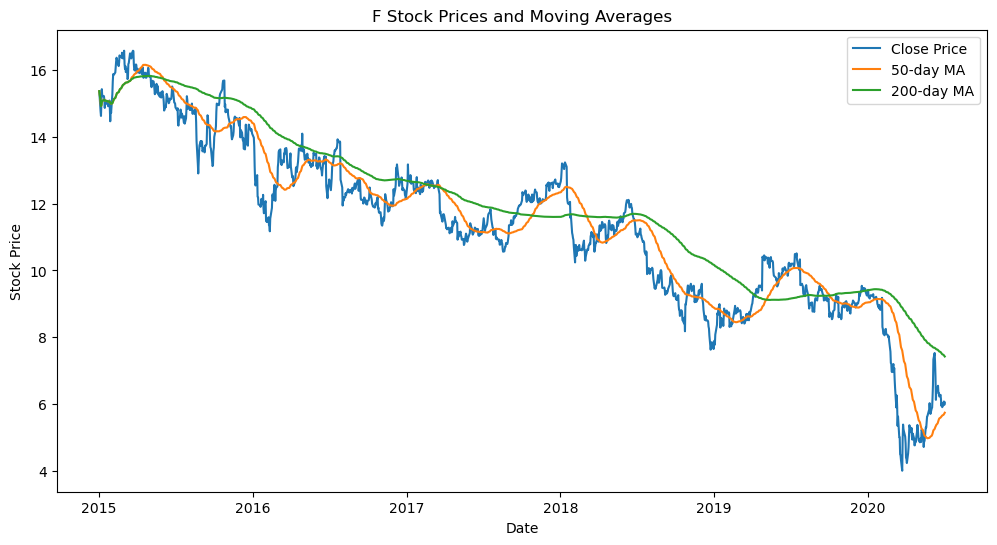

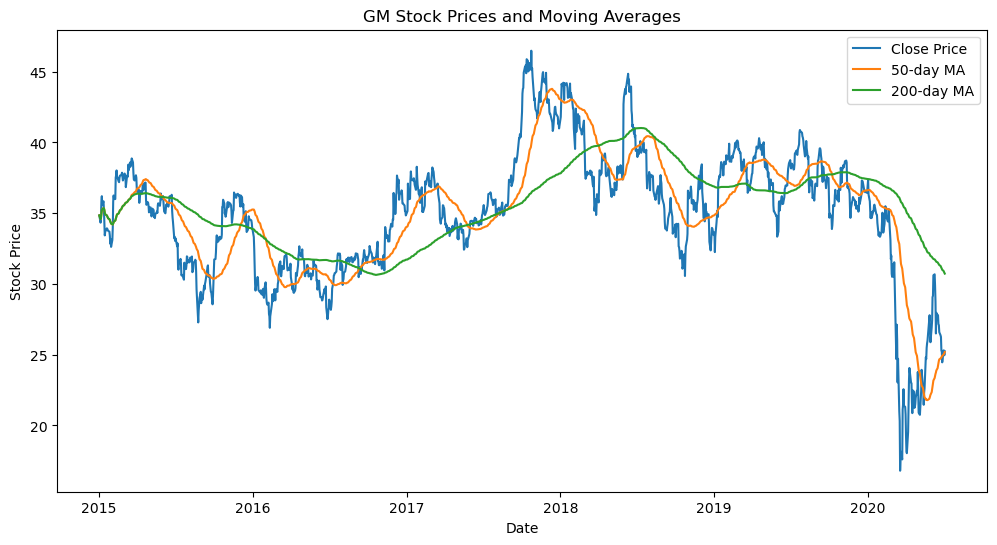

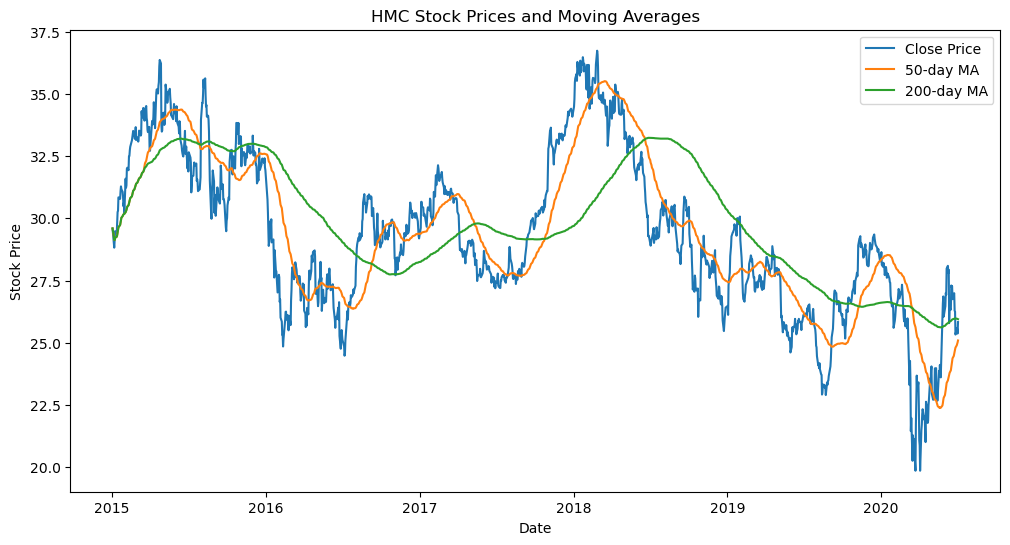

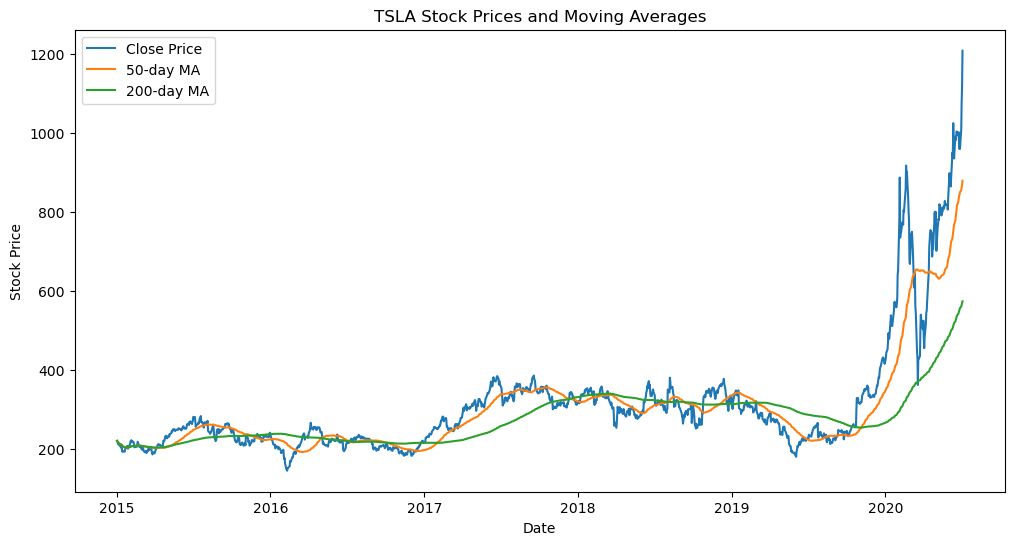

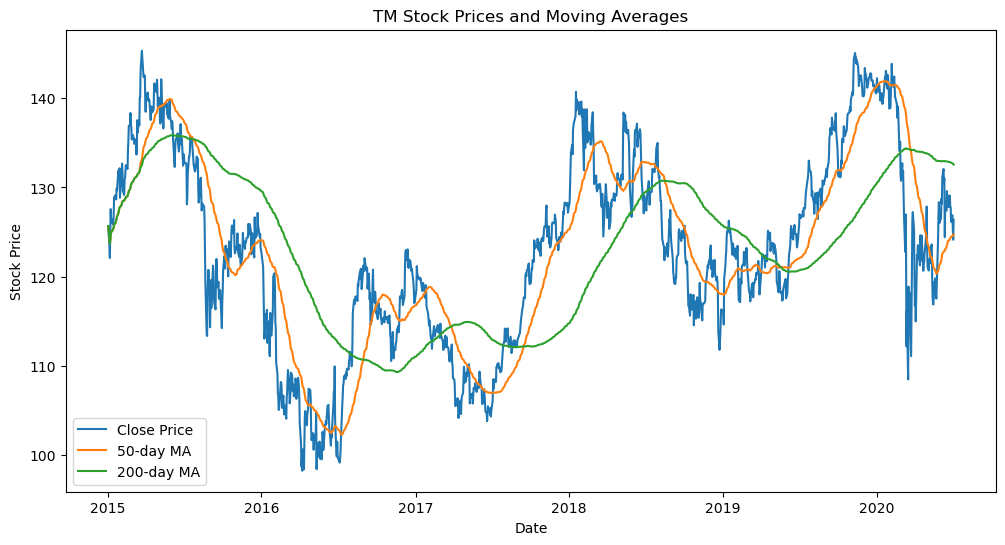

In [16]:
from pyspark.sql.window import Window

# Function to compute moving averages
def compute_moving_average(df, column, window_size):
    window_spec = Window().partitionBy('symbol').orderBy('date').rowsBetween(-window_size, 0)
    return df.withColumn(f'{column}_ma_{window_size}', F.avg(column).over(window_spec))

# Compute 50-day and 200-day moving averages for 'close' prices
selected_car_df = compute_moving_average(selected_car_df, 'close', 50)
selected_car_df = compute_moving_average(selected_car_df, 'close', 200)

# Calculate daily percentage changes
selected_car_df = selected_car_df.withColumn('daily_returns', (col('close') - F.lag('close').over(Window().partitionBy('symbol').orderBy('date'))) / F.lag('close').over(Window().partitionBy('symbol').orderBy('date')))

# Plotting Moving Averages
for company in selected_car_companies:
    company_df = selected_car_df.filter(col('symbol') == company).toPandas()
    
    plt.figure(figsize=(12, 6))
    plt.plot(company_df['date'], company_df['close'], label='Close Price')
    plt.plot(company_df['date'], company_df[f'close_ma_50'], label='50-day MA')
    plt.plot(company_df['date'], company_df[f'close_ma_200'], label='200-day MA')
    
    plt.title(f'{company} Stock Prices and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

__FINDINGS:__

__Stock Price Trends Summary:__

__Ford (F):__

    The 200-day Moving Average (MA) for Ford (F) reveals a consistent decline in stock prices from 2015 to 2020. This indicates a gradual decrease in the value of Ford stocks over the observed period.
    
__General Motors (GM):__

    General Motors (GM) exhibits fluctuating stock prices, with a notable peak observed between 2017 and 2018. Despite fluctuations, the stock price did not exhibit a consistent upward or downward trend during the observed period.
    
__Honda (HMC):__

    Honda's (HMC) stock prices demonstrate high volatility, reaching peaks in 2015-2016 and 2018-2019. Subsequently, the stock exhibits a gradual decline, indicating fluctuating market dynamics.
    
__Tesla (TSLA):__

    Tesla's (TSLA) stock prices remained relatively stable from 2015 to mid-2019, followed by a significant surge after 2020. This suggests a remarkable increase in investor confidence and market value during the latter period.
    
__Toyota (TM):__

    Toyota (TM) experiences the highest level of fluctuation among the selected car companies. The stock price underwent a substantial decline between 2016 and 2017, reflecting the challenges faced by the company during that period.

### 2. Volume

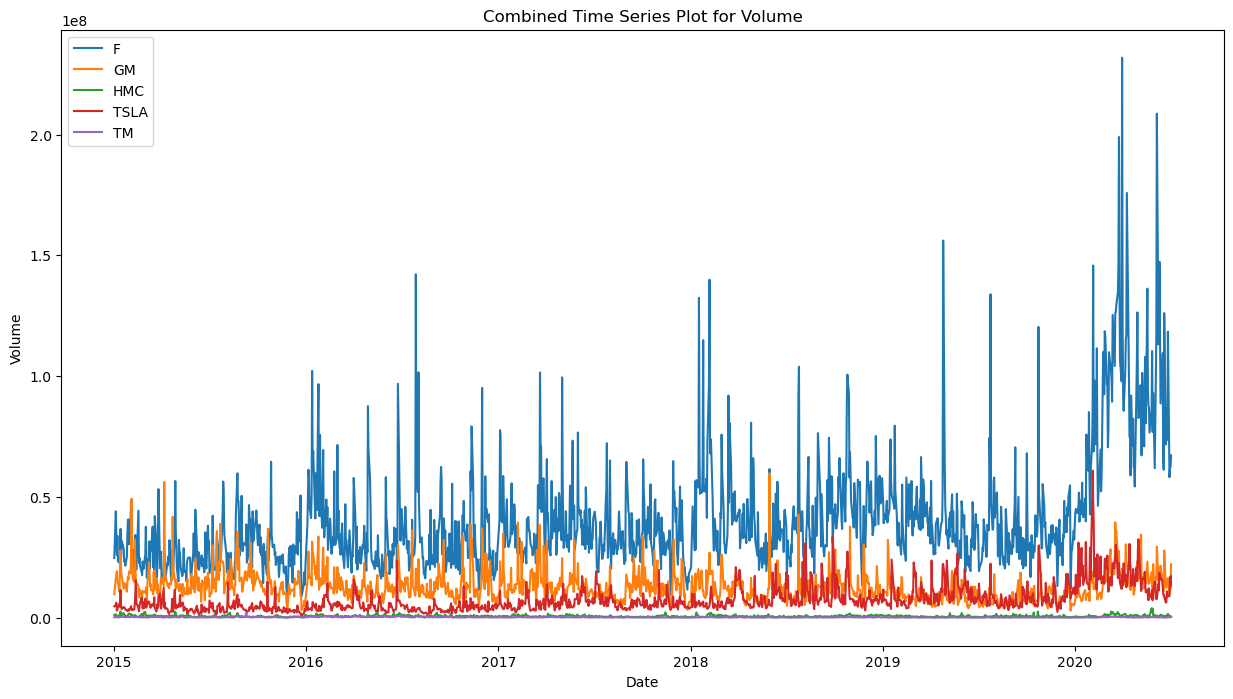

In [22]:
# Set up the plot
plt.figure(figsize=(15, 8))

# Plot time series for the volume for each symbol with different colors
for symbol in selected_car_companies:
    symbol_data = selected_car_df.filter(col('symbol') == symbol).select('date', 'volume').toPandas()

    # Time series plot for volume
    sns.lineplot(x='date', y='volume', data=symbol_data, label=symbol)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Combined Time Series Plot for Volume')

# Show legend
plt.legend()

# Show the plot
plt.show()

__FINDINGS:__

__Volume Comparison:__

     Ford and Tesla: Exhibit higher average trading volumes, indicating robust investor interest and liquidity. Both companies experience frequent and significant trading activity over time.

    Honda and Toyota: Have lower average trading volumes, suggesting a more subdued level of market activity compared to Ford and Tesla. The trading patterns for Honda and Toyota are relatively stable.

__Volatility in Trading Volumes:__

    Tesla: Demonstrates higher volatility in trading volumes, with more pronounced fluctuations. This higher variability could be attributed to Tesla's innovative image, market reactions to news events, and increased speculative trading.

    Other Stocks (Ford, Honda, Toyota): Show lower volatility in trading volumes, indicating more consistent and predictable patterns. This stability could be associated with their established positions in the automotive industry, attracting a steadier level of investor interest.

__Moving Average Method__

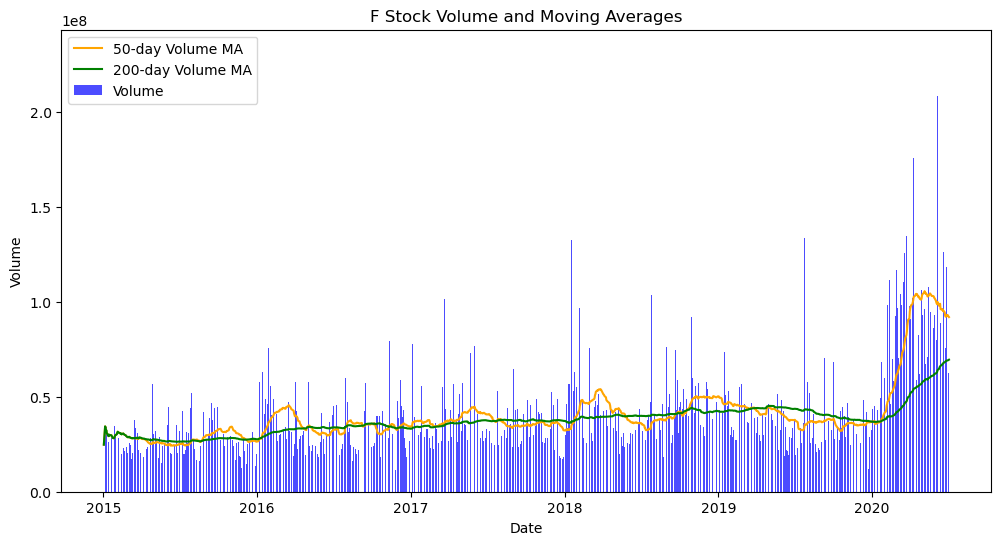

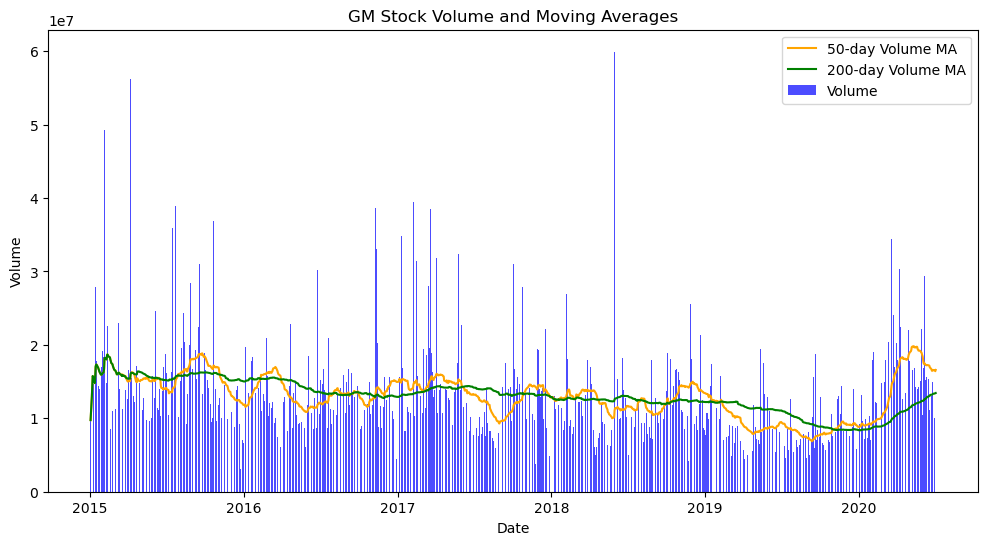

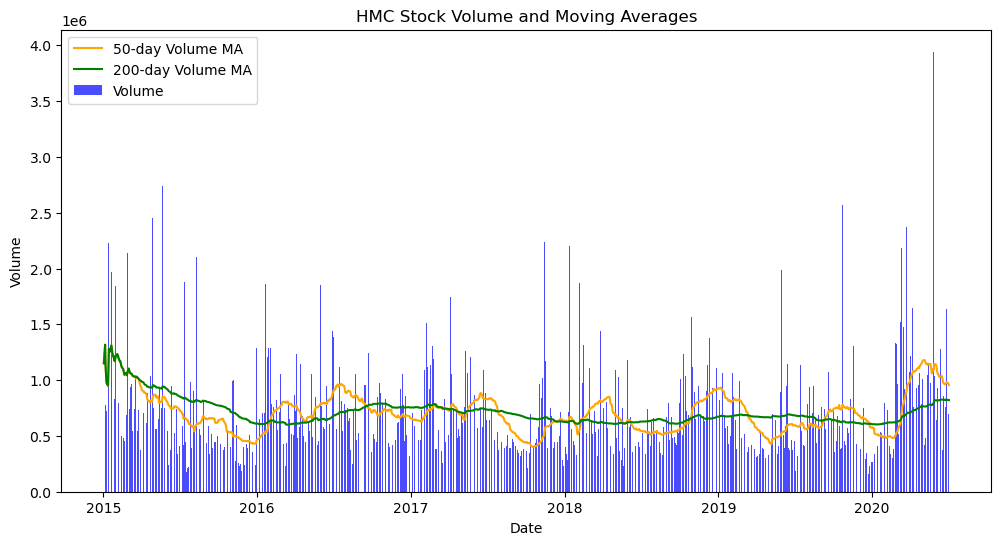

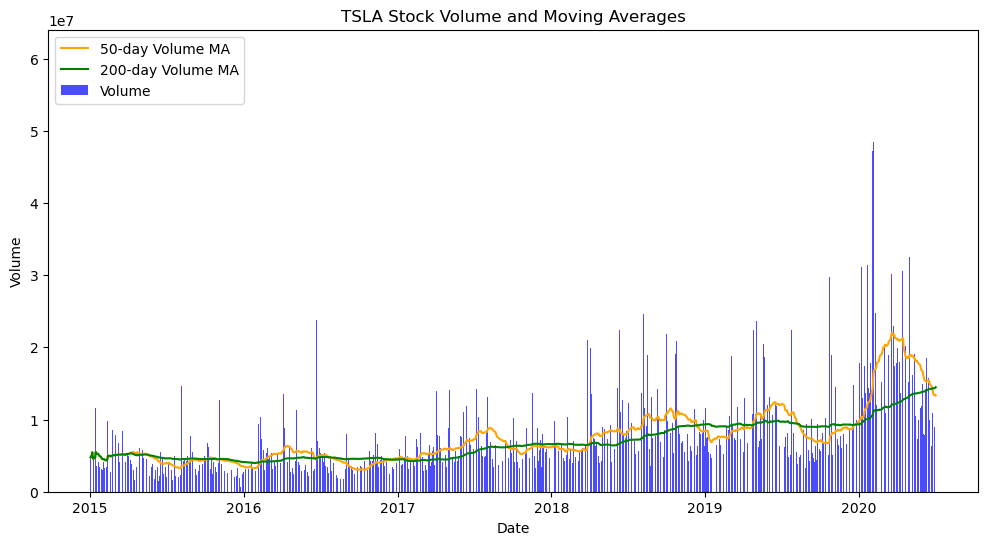

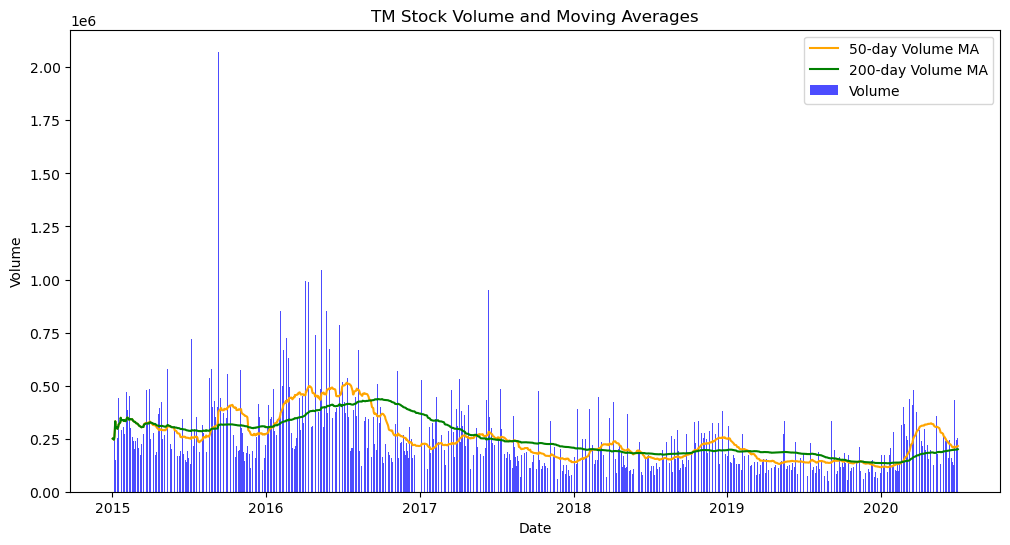

In [17]:
# Function to compute volume moving averages
def compute_volume_moving_average(df, window_size):
    window_spec = Window().partitionBy('symbol').orderBy('date').rowsBetween(-window_size, 0)
    return df.withColumn(f'volume_ma_{window_size}', F.avg('volume').over(window_spec))

# Compute 50-day and 200-day volume moving averages
selected_car_df = compute_volume_moving_average(selected_car_df, 50)
selected_car_df = compute_volume_moving_average(selected_car_df, 200)

# Plotting Volume and Moving Averages
for company in selected_car_companies:
    company_df = selected_car_df.filter(col('symbol') == company).toPandas()
    
    plt.figure(figsize=(12, 6))
    plt.bar(company_df['date'], company_df['volume'], label='Volume', color='blue', alpha=0.7)
    plt.plot(company_df['date'], company_df[f'volume_ma_50'], label='50-day Volume MA', color='orange')
    plt.plot(company_df['date'], company_df[f'volume_ma_200'], label='200-day Volume MA', color='green')
    
    plt.title(f'{company} Stock Volume and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

__FINDINGS :__

Based on the moving average method applied to the 200-day volume moving average (MA), the observed trends for each stock are as follows:

__F (Ford):__

    Exhibits a generally increasing trend in stock volume over time, with a noticeable dip in 2020. The volume quickly recovered and experienced a significant surge.

__GM (General Motors):__

    Demonstrates a stable trend in stock volume over the observed period, even though it reached 6 million stocks at a point between 2018-2019.

__HMC (Honda Motor Company):__

    Shows a consistently stable trend in stock volume over time, without major fluctuations.

__TSLA (Tesla):__

    Indicates a steady and rising trend in stock volume, suggesting sustained market interest and trading activity.

__TM (Toyota Motor):__

    Displays a stable trend in stock volume over time; however, there is a notable observation of a decreasing trend after 2017, signaling a potential shift in market dynamics.

### Daily Return

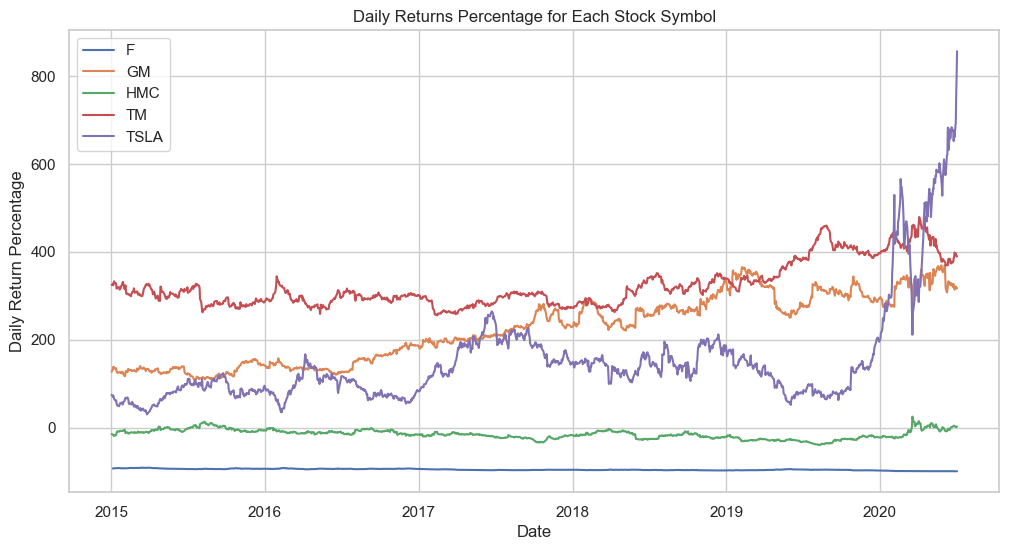

In [103]:
# Assuming you have a SparkSession named spark
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming selected_car_df is your initial DataFrame and symbols is a list of stock symbols
windowSpec = Window().orderBy('date')

# Calculate daily returns using lag function within the Window
selected_car_df = selected_car_df.withColumn('lag_close', F.lag('close').over(windowSpec))
selected_car_df = selected_car_df.withColumn('daily_return', (F.col('close') / F.col('lag_close') - 1) * 100)

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_car_df.toPandas()

plt.figure(figsize=(12, 6))

for symbol in symbols:
    symbol_data = pandas_df[pandas_df['symbol'] == symbol]
    
    plt.plot(symbol_data['date'], symbol_data['daily_return'], label=symbol)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Daily Return Percentage')
plt.title('Daily Returns Percentage for Each Stock Symbol')
plt.legend()
plt.show()

__FINDINGS:__

    In the period from 2015 to 2020, Toyota Motors (TM) consistently led in daily return percentages, closely followed by General Motors (GM). However, 2020 marked a significant shift as Tesla (TSLA) stocks surged, surpassing TM and GM. Meanwhile, Honda Motors (HMC) and Ford (F) exhibited lower and stable daily returns throughout the analyzed period, with Ford showcasing a notably consistent performance.

### Correlation Heatmap

__1. Overall Correlation__

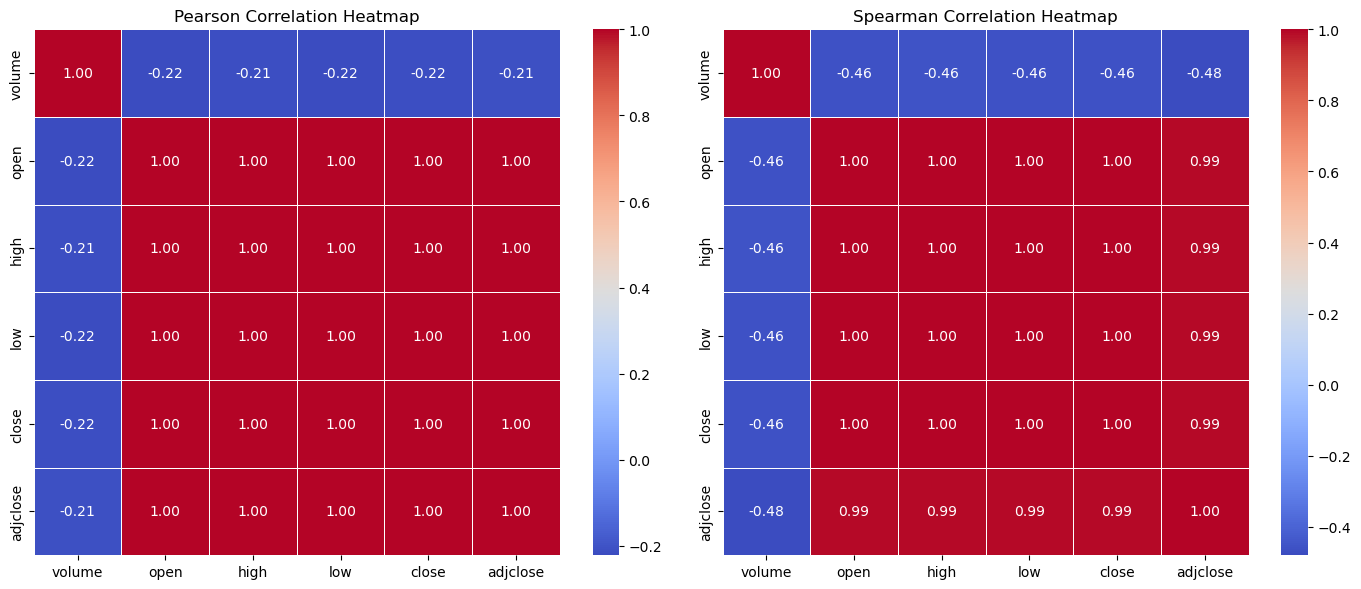

In [19]:

# Select only numerical columns
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Filter DataFrame to include only numerical columns
numerical_df = selected_car_df.select(*numerical_columns)

# Convert the filtered DataFrame to Pandas for correlation calculation and visualization
pandas_df = numerical_df.toPandas()

# Calculate Pearson correlation
pearson_corr = pandas_df.corr(method='pearson')

# Calculate Spearman correlation
spearman_corr = pandas_df.corr(method='spearman')

# Set up subplots for visualizations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Pearson correlation heatmap
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[0])
axes[0].set_title('Pearson Correlation Heatmap')

# Plot Spearman correlation heatmap
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[1])
axes[1].set_title('Spearman Correlation Heatmap')

plt.tight_layout()
plt.show()

__2. Stockwise Correlation__

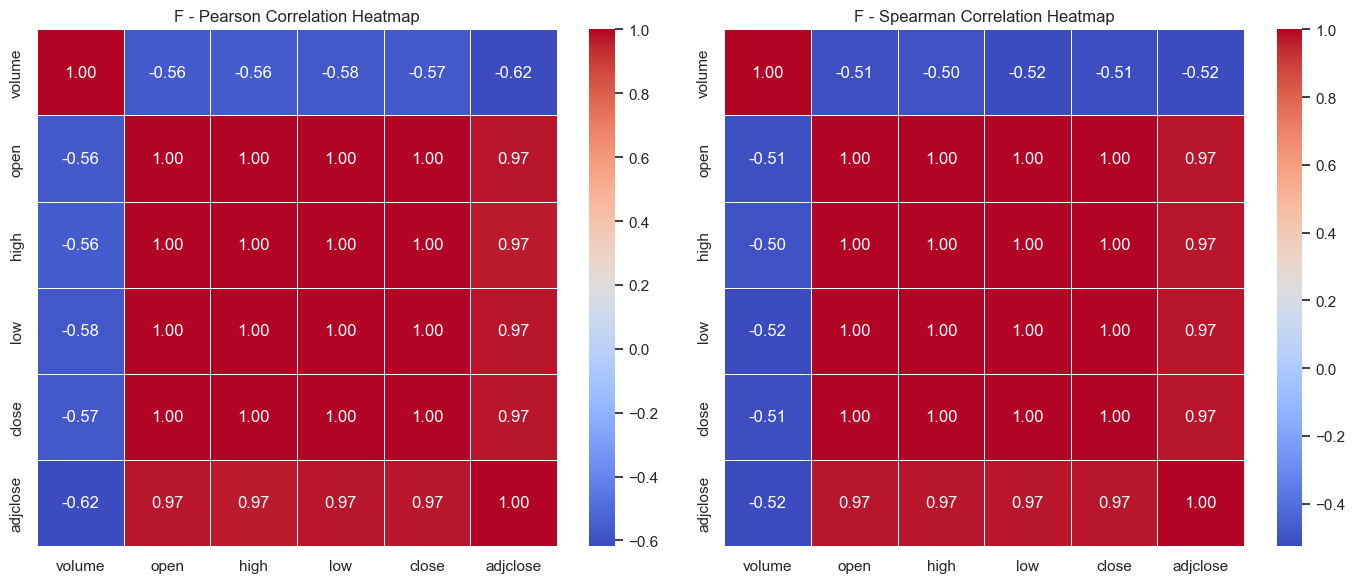

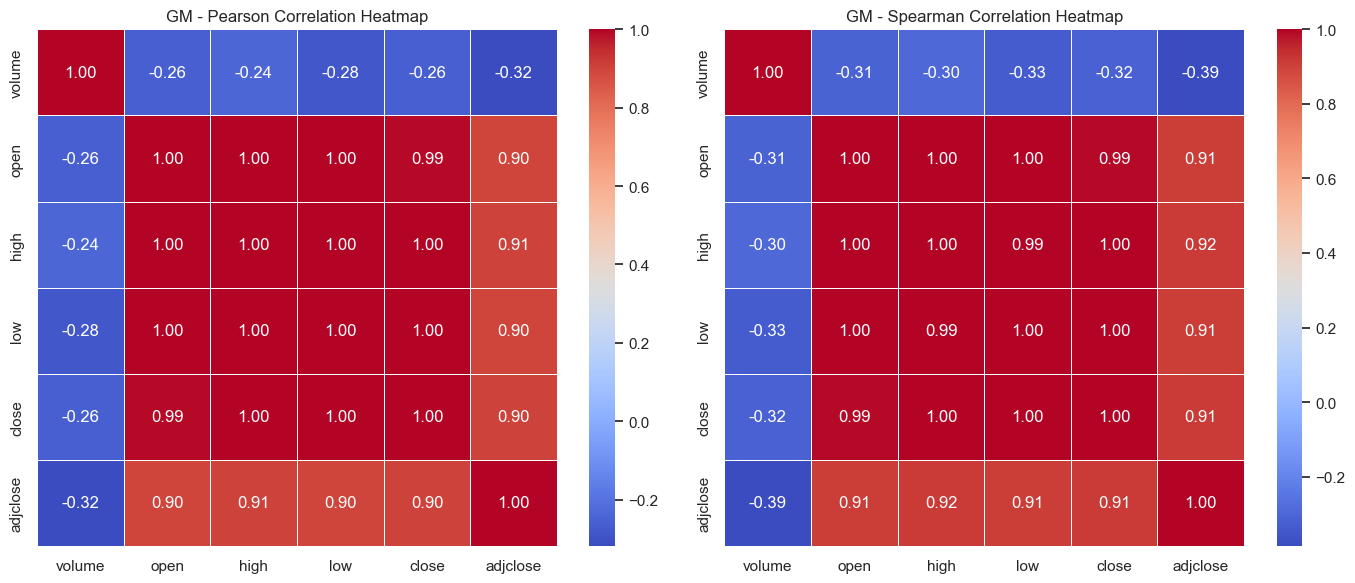

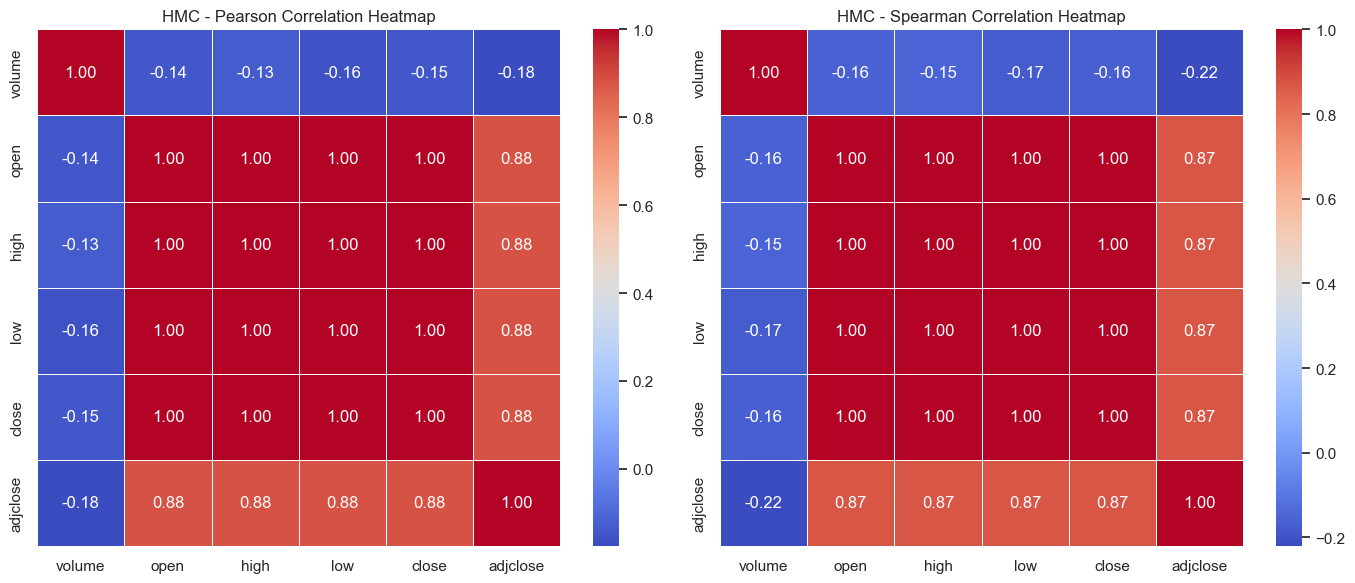

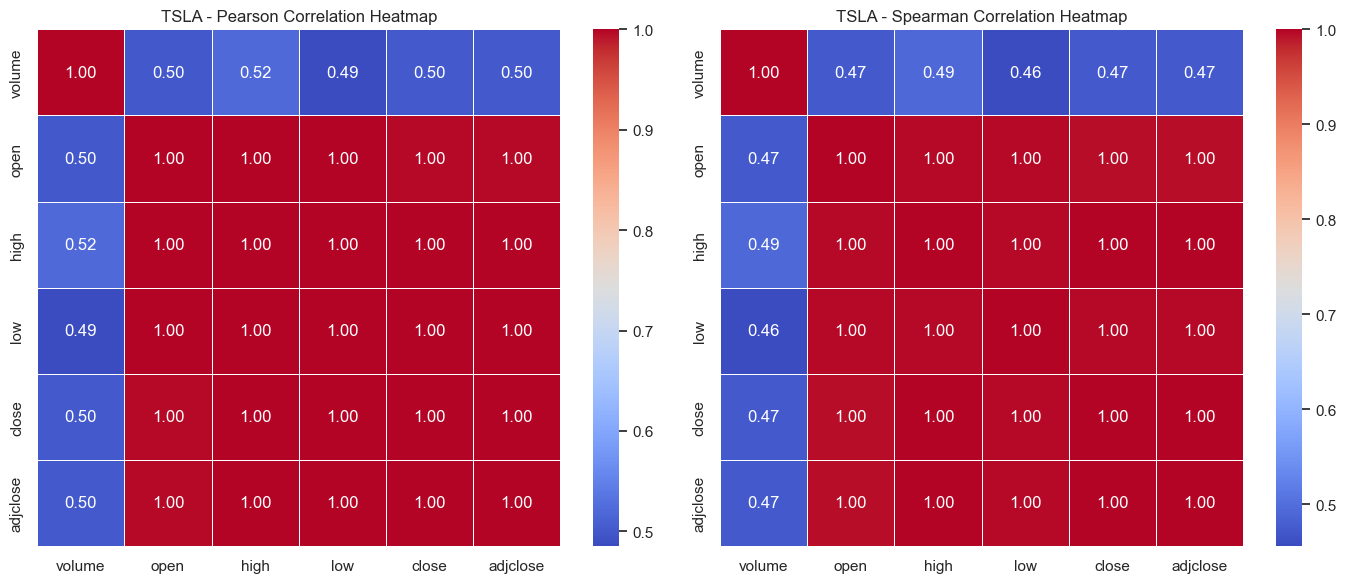

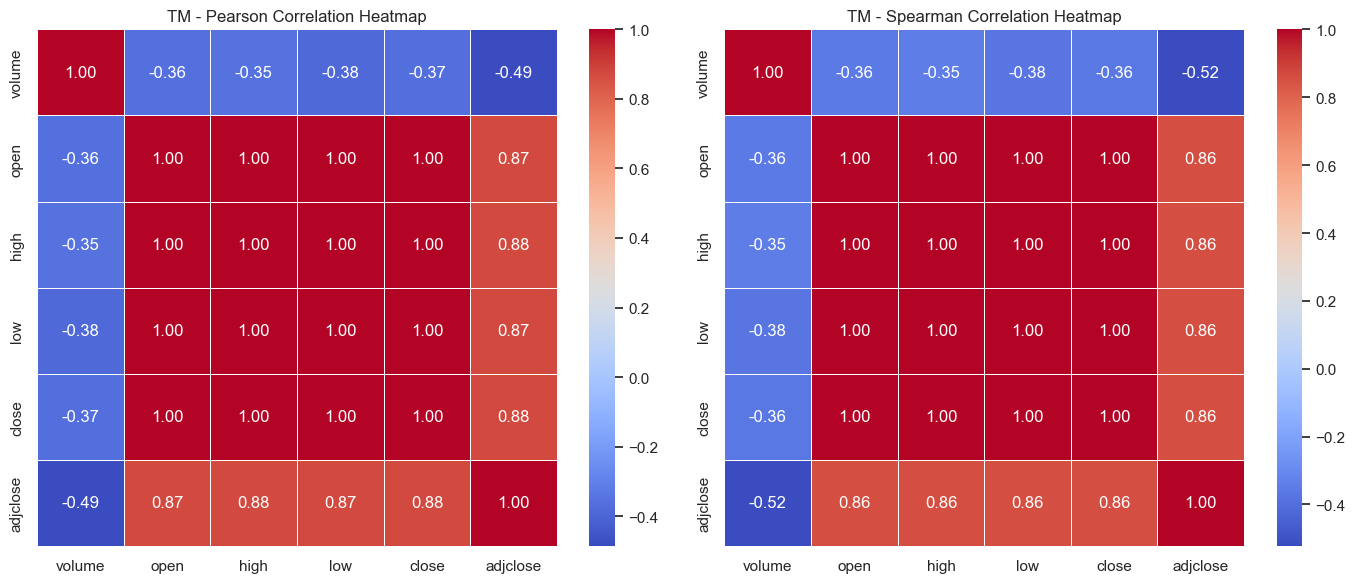

In [94]:
# Assuming full_stock_df is your original DataFrame

# List of selected car companies
selected_car_companies = ["F", "GM", "HMC", "TSLA", "TM"]

# Initialize Spark session
spark = SparkSession.builder.master("local").appName("CarCompanyCorrelation").getOrCreate()

# Assuming full_stock_df is your original DataFrame
# Filter DataFrame for selected car companies
selected_car_df = full_stock_df.filter(col('symbol').isin(selected_car_companies))

# Select only numerical columns
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Create a separate correlation analysis for each car company
for company in selected_car_companies:
    # Filter DataFrame for the specific car company
    company_df = selected_car_df.filter(col('symbol') == company)

    # Filter DataFrame to include only numerical columns
    numerical_df = company_df.select(*numerical_columns)

    # Convert the filtered DataFrame to Pandas for correlation calculation and visualization
    pandas_df = numerical_df.toPandas()

    # Calculate Pearson correlation
    pearson_corr = pandas_df.corr(method='pearson')

    # Calculate Spearman correlation
    spearman_corr = pandas_df.corr(method='spearman')

    # Set up subplots for visualizations
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Plot Pearson correlation heatmap
    sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[0])
    axes[0].set_title(f'{company} - Pearson Correlation Heatmap')

    # Plot Spearman correlation heatmap
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axes[1])
    axes[1].set_title(f'{company} - Spearman Correlation Heatmap')

    plt.tight_layout()
    plt.show()

__FINDINGS:__

In the Pearson correlation analysis, Ford (F) exhibits strong positive correlations among its price-related columns, while General Motors (GM), Honda (HMC), and Toyota (TM) show moderate to strong positive correlations. Tesla (TSLA) stands out with very strong positive correlations between its price-related columns. Additionally, all companies display varying degrees of negative correlations with trading volume, indicating potential inverse relationships.

In the Spearman correlation analysis, the trends remain consistent with the Pearson results, reflecting similar patterns of associations between the numerical variables for each car company. These correlation insights provide a snapshot of the linear relationships within the selected car companies' stock data, offering valuable information for investors and analysts in understanding potential dependencies between trading volume and price-related metrics.

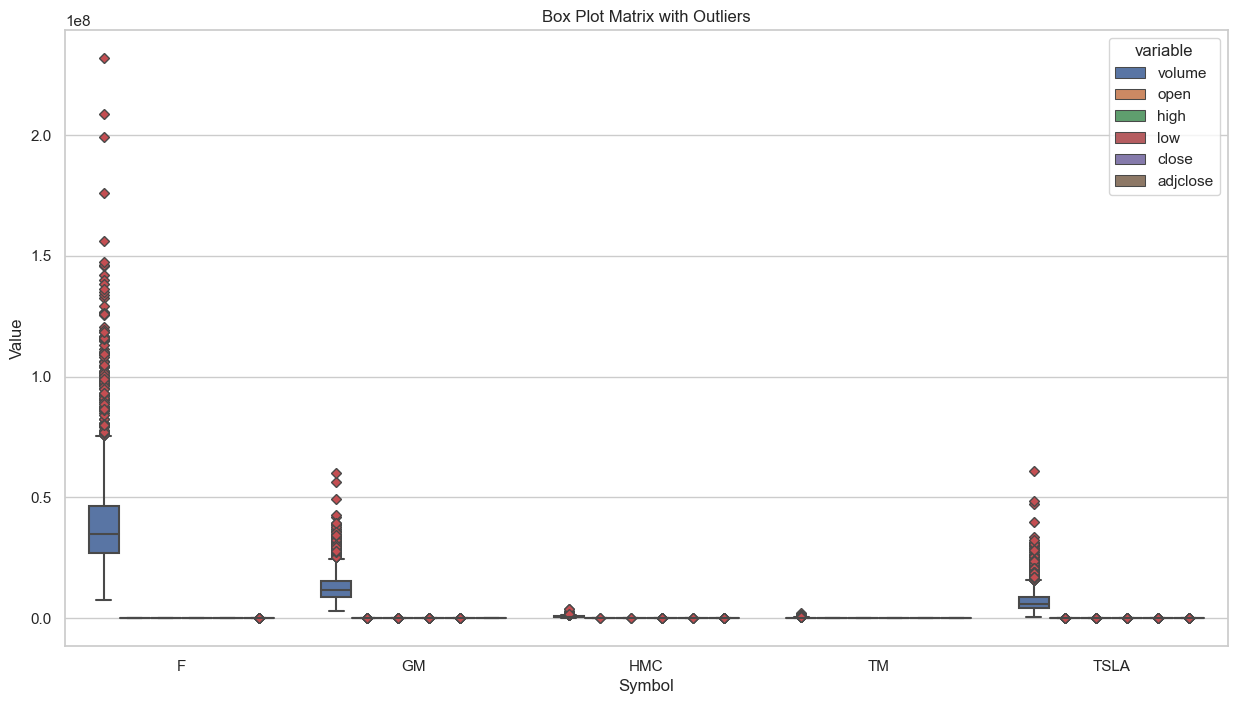

In [20]:
pandas_df = selected_car_df.toPandas()

# Select numerical columns for the box plot matrix
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Reshape the data into long format for box plot matrix
melted_df = pandas_df.melt(id_vars=['symbol'], value_vars=numerical_columns, var_name='variable')

# Create box plot matrix
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")
sns.boxplot(data=melted_df, x='symbol', y='value', hue='variable', showfliers=True,
            flierprops=dict(markerfacecolor='r', marker='D'))

# Set plot labels and title
plt.xlabel('Symbol')
plt.ylabel('Value')
plt.title('Box Plot Matrix with Outliers')

plt.show()

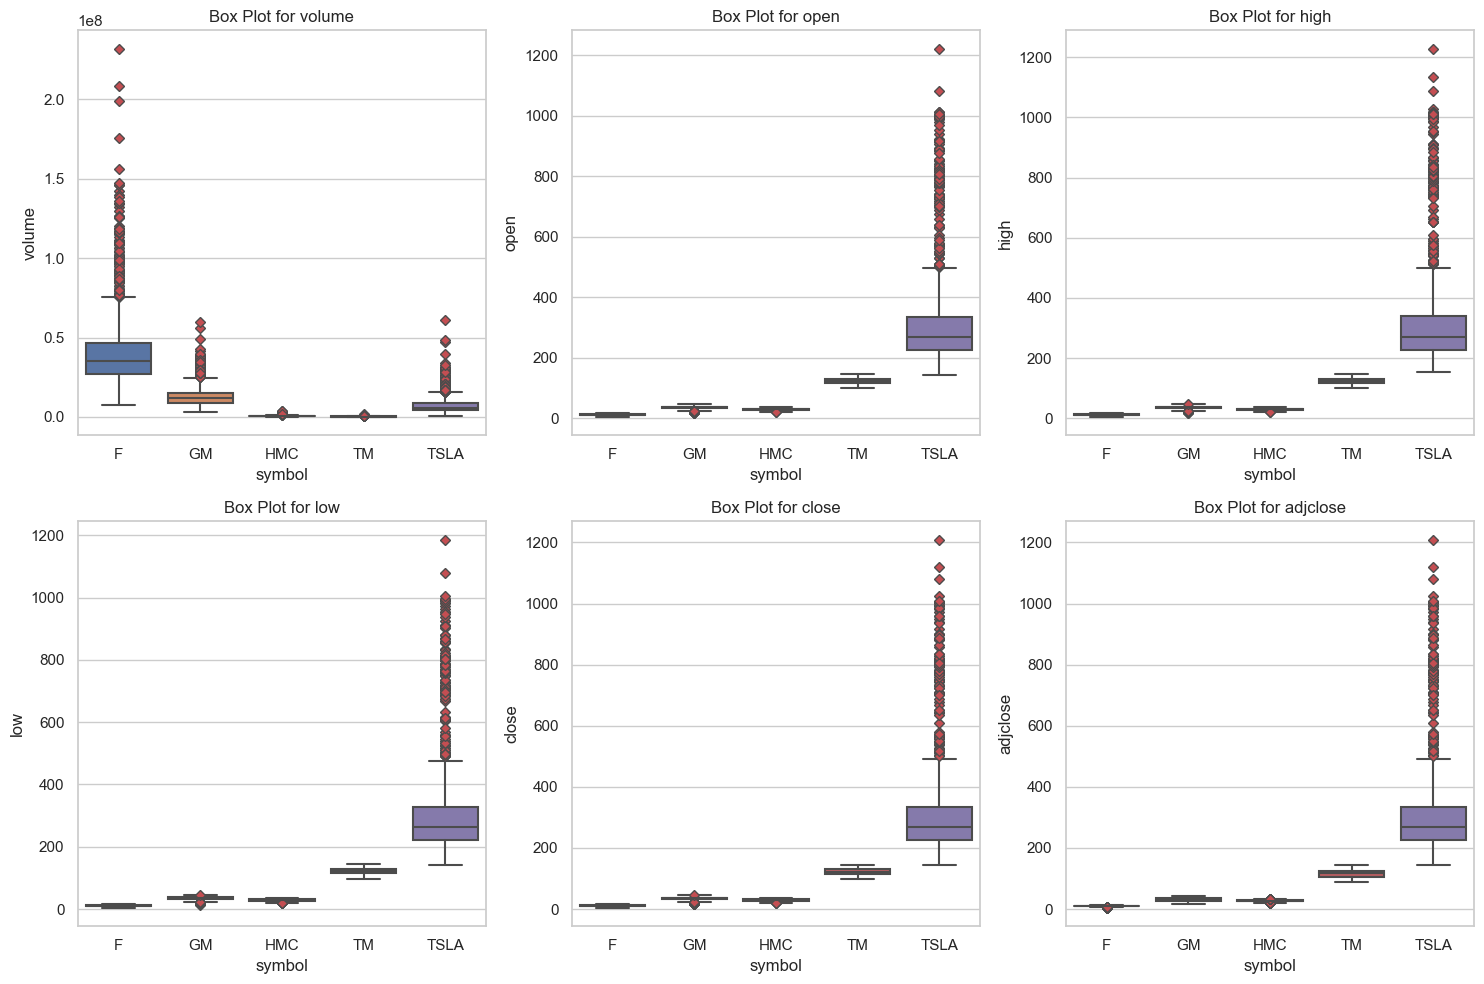

In [21]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_car_df.toPandas()

# Select numerical columns for the box plot
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Create box plots for each numerical variable grouped by 'symbol'
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

for numerical_column in numerical_columns:
    plt.subplot(2, 3, numerical_columns.index(numerical_column) + 1)
    sns.boxplot(data=pandas_df, x='symbol', y=numerical_column, showfliers=True,
                flierprops=dict(markerfacecolor='r', marker='D'))
    plt.title(f'Box Plot for {numerical_column}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

__FINDINGS:__

__Volume Column:__
* All stocks exhibit outliers, indicating variability in trading volumes.

__Close Price Column:__
* Tesla (TSLA) consistently shows a high number of outliers above the maximum whisker.
* General Motors (GM) and Honda (HMC) display fewer outliers.
* Ford (F) and Toyota (TM) have no outliers in the close price column.

__Significance:__
* Outlier patterns provide insights into the stock behavior and potential areas of interest for further analysis, especially noting Tesla's distinctive presence in terms of outliers.

In [24]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

# Assuming 'selected_car_df' is your PySpark DataFrame
# Select numerical columns for normalization
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Create an empty DataFrame to store the normalized data
normalized_df = selected_car_df

# Normalize each column separately using MinMaxScaler
for column in numerical_columns:
    assembler = VectorAssembler(inputCols=[column], outputCol=f"{column}_vector")
    scaler = MinMaxScaler(inputCol=f"{column}_vector", outputCol=f"scaled_{column}")
    pipeline = Pipeline(stages=[assembler, scaler])
    model = pipeline.fit(normalized_df)
    normalized_df = model.transform(normalized_df)

# Display the first few rows of the normalized DataFrame
normalized_df.select(['symbol'] + [f'scaled_{column}' for column in numerical_columns]).show(5, truncate=False)

+------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|symbol|scaled_volume        |scaled_open            |scaled_high            |scaled_low             |scaled_close           |scaled_adjclose        |
+------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|F     |[0.2899534158006562] |[0.0015034381520373677]|[0.001430229327145849] |[0.0017264141397275545]|[0.0016934378486360736]|[0.0016934378486360736]|
|F     |[0.26928005923563253]|[0.0015034381520373677]|[0.0014384018635106967]|[0.0016840999054687795]|[0.0016353295435777146]|[0.0016353295435777146]|
|F     |[0.26692668554888754]|[0.0014048521336159706]|[0.0013730200137656511]|[0.0016417860747484486]|[0.0017183411252107684]|[0.0017183411252107684]|
|F     |[0.25095748738740137]|[0.0013473434269971473]|[0.0013485020149645427]|[0.0015656206144

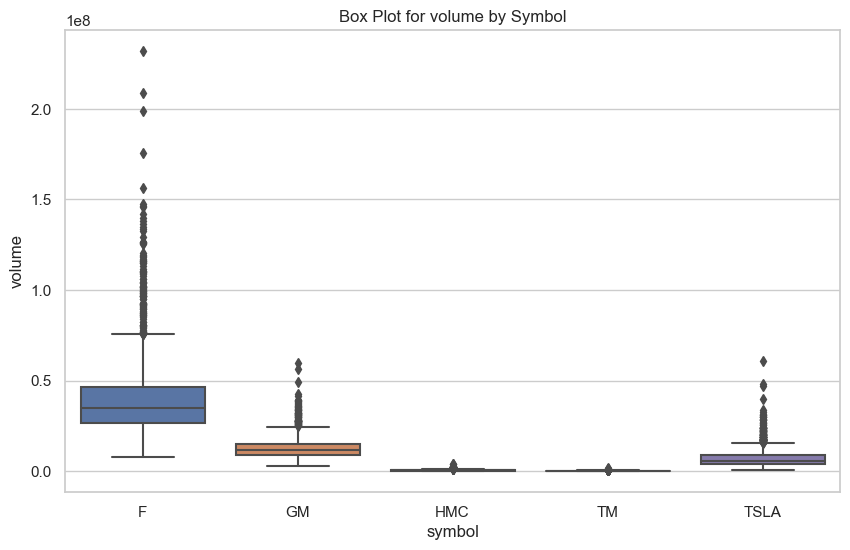

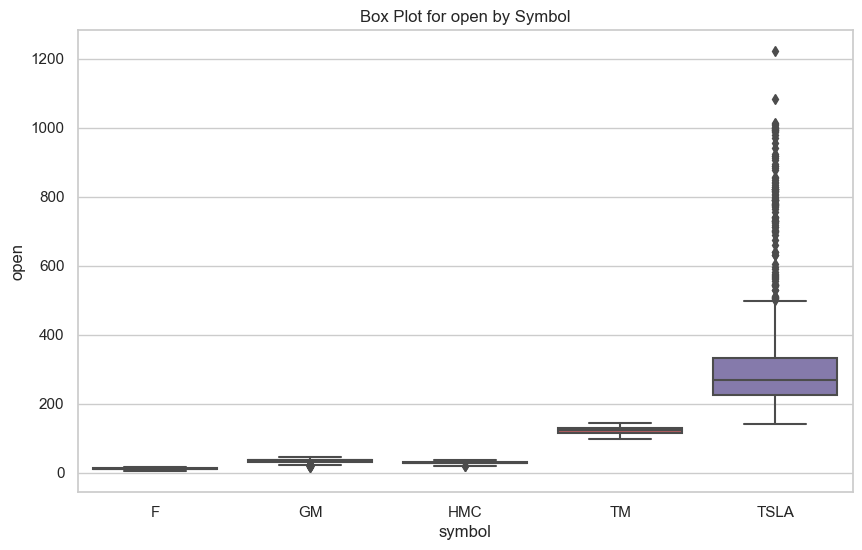

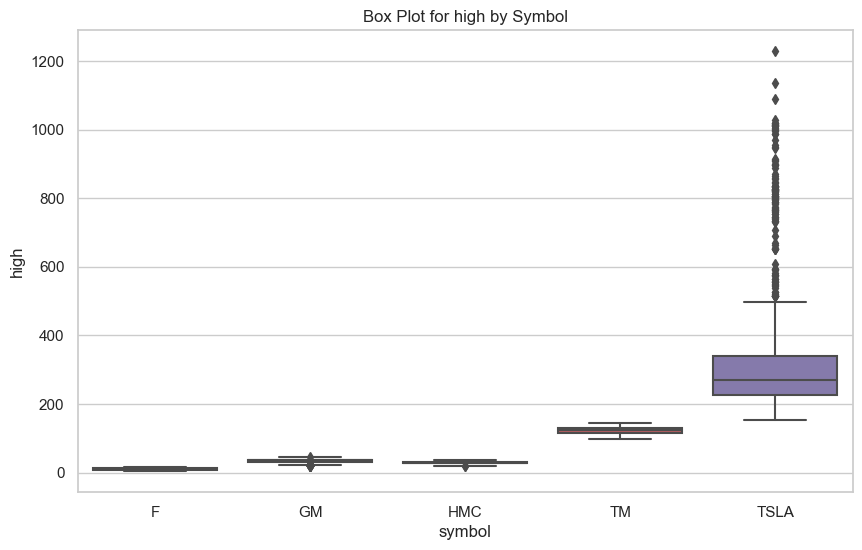

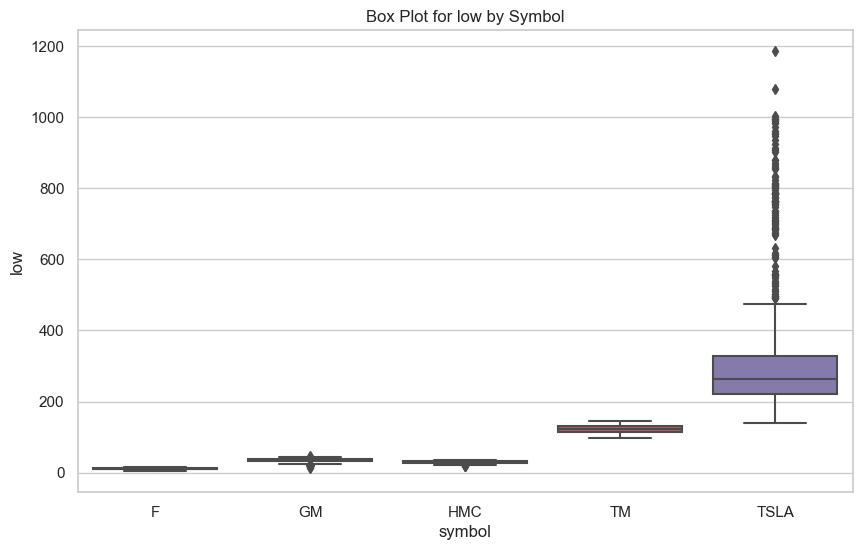

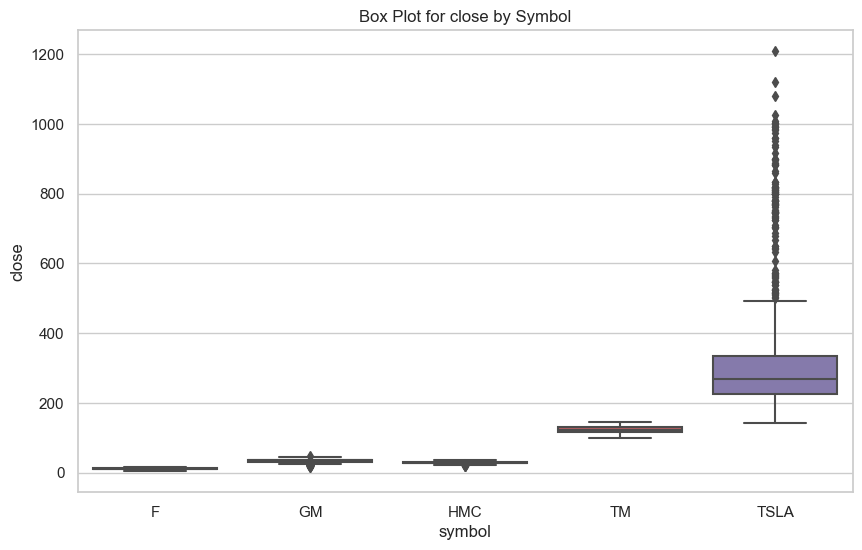

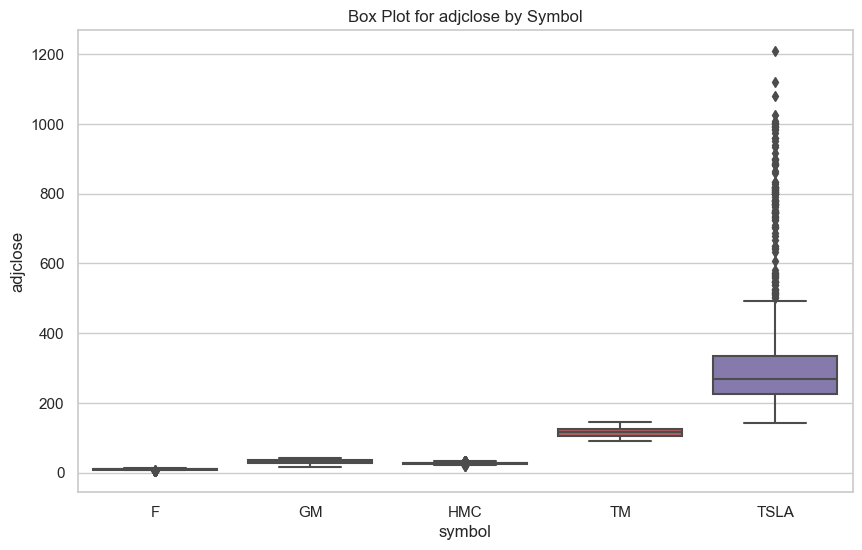

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = selected_car_df.toPandas()

# Select numerical columns
numerical_columns = ['volume', 'open', 'high', 'low', 'close', 'adjclose']

# Create box plots for each numerical column, grouped by 'symbol'
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='symbol', y=column, data=pandas_df)
    plt.title(f'Box Plot for {column} by Symbol')
    plt.show()

## <u>Step 2: Predictive Analysis</u>

In [32]:
#Create the spark session
findspark.init()
spark = SparkSession.builder.appName("PredictiveAnalysis").getOrCreate()

# List of selected car companies
selected_car_companies = ["F", "GM", "HMC", "TSLA", "TM"]

#load data from the file
full_stock_df = spark.read.load("fh_5yrs.csv", format="csv", sep=",", header="true", inferSchema=True)

# Filter DataFrame for selected car companies
final_selected_car_df = full_stock_df.filter(col('symbol').isin(selected_car_companies))

#Display the filtered DataFrame
final_selected_car_df.show()

+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|      date|   volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02| 67245800|6.0999999046325675| 6.170000076293945|               6.0| 6.050000190734862| 6.050000190734862|     F|
|2020-07-01| 62454700|6.0999999046325675| 6.179999828338622| 5.949999809265138| 5.980000019073486| 5.980000019073486|     F|
|2020-06-30| 61909300| 5.980000019073486|6.0999999046325675|5.9000000953674325| 6.079999923706055| 6.079999923706055|     F|
|2020-06-29| 58208400|5.9099998474121085| 6.070000171661378| 5.809999942779541| 6.010000228881836| 6.010000228881836|     F|
|2020-06-26|118435400| 6.039999961853027| 6.070000171661378| 5.809999942779541|5.9099998474121085|5.9099998474121085|     F|


In [38]:
# Step 1: Filter the data for Ford and assign it to ford_df
ford_spark = final_selected_car_df.filter(col('symbol') == 'F')

# Display the filtered DataFrame
ford_spark.show()

+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|      date|   volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+---------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02| 67245800|6.0999999046325675| 6.170000076293945|               6.0| 6.050000190734862| 6.050000190734862|     F|
|2020-07-01| 62454700|6.0999999046325675| 6.179999828338622| 5.949999809265138| 5.980000019073486| 5.980000019073486|     F|
|2020-06-30| 61909300| 5.980000019073486|6.0999999046325675|5.9000000953674325| 6.079999923706055| 6.079999923706055|     F|
|2020-06-29| 58208400|5.9099998474121085| 6.070000171661378| 5.809999942779541| 6.010000228881836| 6.010000228881836|     F|
|2020-06-26|118435400| 6.039999961853027| 6.070000171661378| 5.809999942779541|5.9099998474121085|5.9099998474121085|     F|


### Data Preperation

In [39]:
# Convert the PySpark DataFrame 'ford_spark' to a Pandas DataFrame 'ford_df'
ford_df = ford_spark.toPandas()

In [40]:
ford_df.isnull().sum()

date        0
volume      0
open        0
high        0
low         0
close       0
adjclose    0
symbol      0
dtype: int64

In [41]:
ford_df = ford_df.drop('symbol', axis = 1)

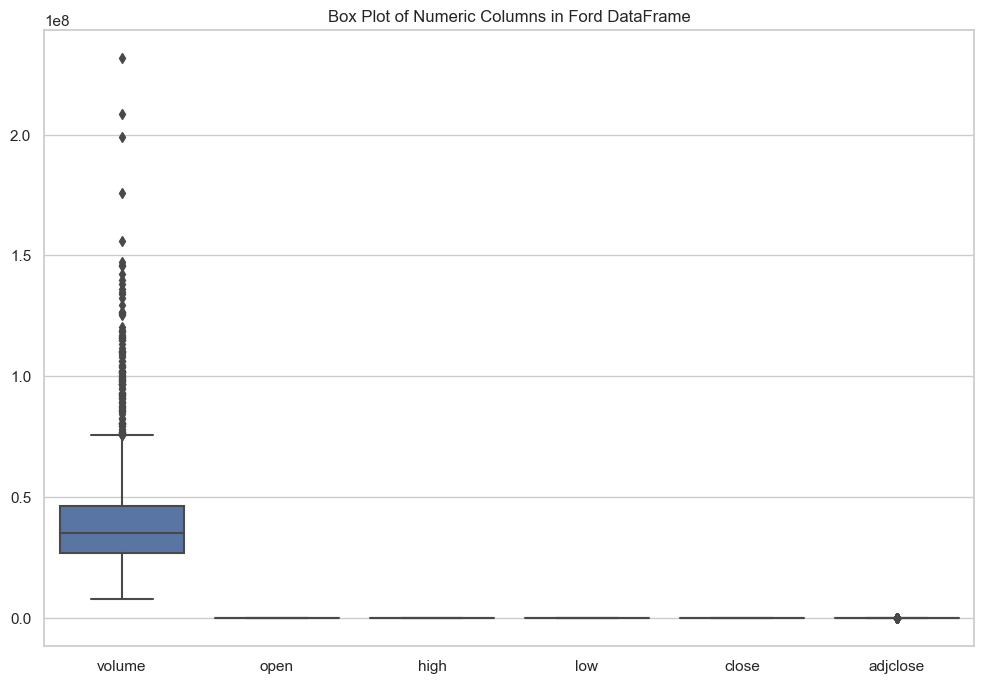

In [42]:
numeric_columns = ford_df.select_dtypes(include=['float64', 'int64']).columns

# Create a box plot for each numeric column
plt.figure(figsize=(12, 8))
sns.boxplot(data=ford_df[numeric_columns])
plt.title('Box Plot of Numeric Columns in Ford DataFrame')
plt.show()

In [43]:
ford_df.shape

(1385, 7)

In [44]:
#check the columns of the dataframe to cross check
print(ford_df.columns)

Index(['date', 'volume', 'open', 'high', 'low', 'close', 'adjclose'], dtype='object')


In [45]:
ford_df

,date,volume,open,high,low,close,adjclose
0,2020-07-02,67245800,6.10,6.17,6.00,6.05,6.050000
1,2020-07-01,62454700,6.10,6.18,5.95,5.98,5.980000
2,2020-06-30,61909300,5.98,6.10,5.90,6.08,6.080000
3,2020-06-29,58208400,5.91,6.07,5.81,6.01,6.010000
4,2020-06-26,118435400,6.04,6.07,5.81,5.91,5.910000
...,...,...,...,...,...,...,...
1380,2015-01-08,33943400,15.40,15.48,15.23,15.42,11.720727
1381,2015-01-07,26065300,14.78,15.09,14.77,15.04,11.431887
1382,2015-01-06,32981600,14.88,14.90,14.38,14.62,11.112647
1383,2015-01-05,44079700,15.12,15.13,14.69,14.76,11.219061


In [46]:
# Create a new Pandas DataFrame 'n_df' by resetting the index of 'ford_df' and selecting the 'close' column
n_df = ford_df.reset_index()['close']

In [47]:
# For processing
import random
import datetime as dt
import math
import matplotlib.dates as mdates


# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [48]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(np.array(n_df).reshape(-1,1))

In [49]:
scaled_data.shape

(1385, 1)

In [50]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [51]:
# Define the sequence length (number of past time steps)
n_past = 100

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [52]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1008, 100)
(1008,)


Testing set size:-
(177, 100)
(177,)


(None, None)

In [53]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model Training

In [54]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))



In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [57]:
# Compiling the model
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
# Training our lstm model
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,validation_split=0.1)

Epoch 1/50

16/16 [==============================] - 11s 285ms/step - loss: 0.0596 - val_loss: 0.0598
Epoch 2/50
16/16 [==============================] - 2s 144ms/step - loss: 0.0080 - val_loss: 0.0322
Epoch 3/50
16/16 [==============================] - 2s 145ms/step - loss: 0.0058 - val_loss: 0.0175
Epoch 4/50
16/16 [==============================] - 2s 144ms/step - loss: 0.0051 - val_loss: 0.0088
Epoch 5/50
16/16 [==============================] - 2s 146ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 6/50
16/16 [==============================] - 2s 154ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 7/50
16/16 [==============================] - 3s 180ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 8/50
16/16 [==============================] - 2s 150ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 9/50
16/16 [==============================] - 2s 145ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 10/50
16/16 [==============================] - 2s 143ms/step - loss: 0.0040 - val_loss: 0.00

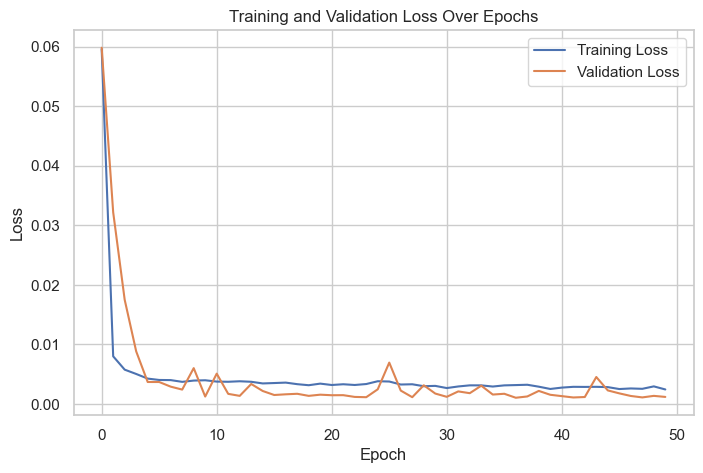

In [59]:
# Plot training loss and validation loss across epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 57ms/step


In [61]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [62]:
# Inverse transform the scaled target variables 'y_train' and 'y_test' using the 'scaler'
# This is done to revert the scaling and obtain the original values for better interpretation or evaluation
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
# Calculate train data RMSE
print('train data RMSE:',math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print('test data RMSE :', math.sqrt(mean_squared_error(y_test,test_predict)))

train data RMSE: 0.40017267341077845
test data RMSE : 0.4352903442135513


In [64]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, test_predict)
Accuracy = 1 - MAPE

print('MAPE :',MAPE)
print('Accuracy :',Accuracy)

MAPE : 0.02342320652782436
Accuracy : 0.9765767934721756


In [65]:
from sklearn.metrics import r2_score


r2 = r2_score(y_train, train_predict)
print(f'R-squared train: {r2}')

r2 = r2_score(y_test, test_predict)
print(f'R-squared test: {r2}')

R-squared train: 0.9336030211913716
R-squared test: 0.6934693450480307


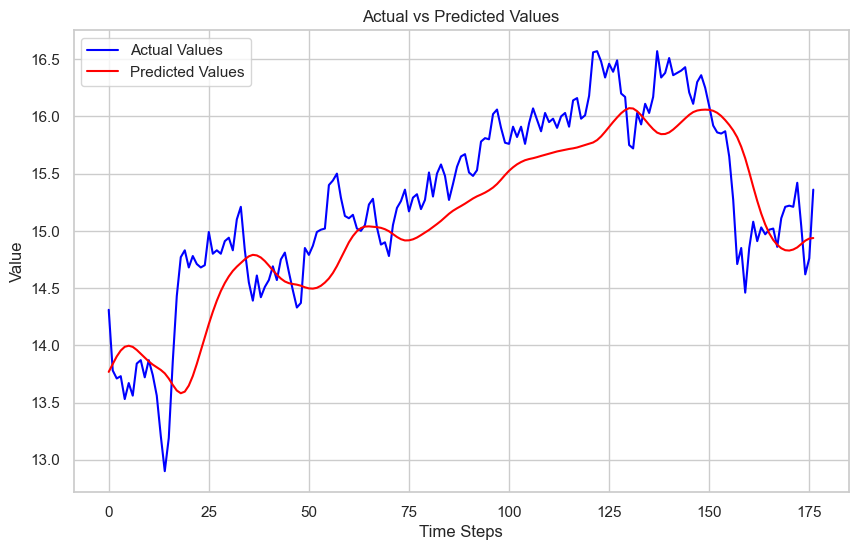

In [66]:
# Visualize the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(test_predict, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

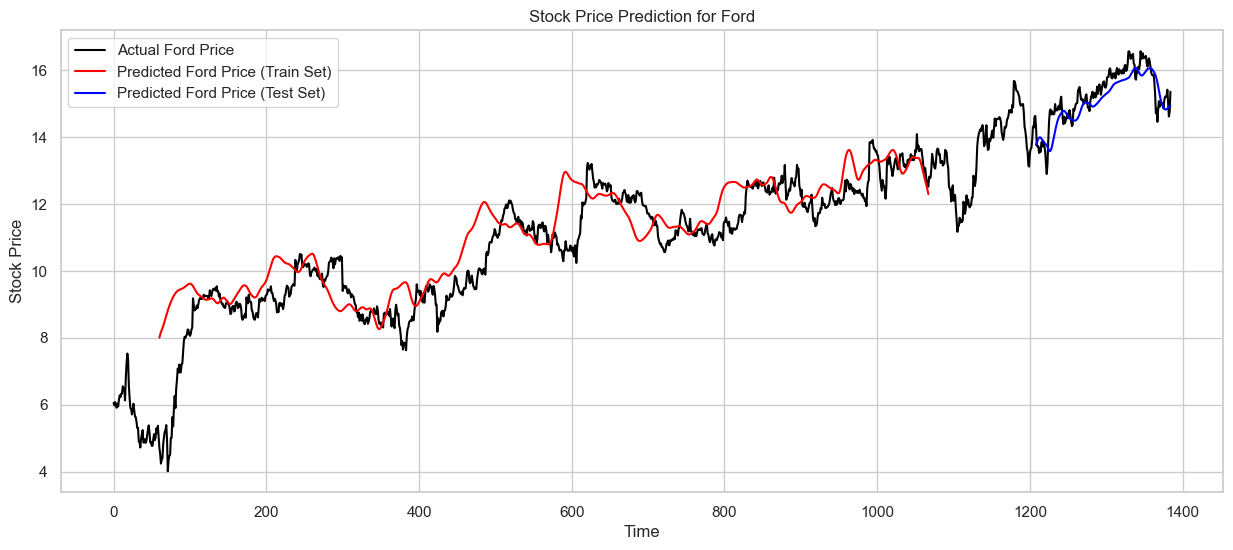

In [67]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(scaled_data) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label="Actual Ford Price")
plt.plot(trainPredictPlot, color='red', label="Predicted Ford Price (Train Set)")
plt.plot(testPredictPlot, color='blue', label="Predicted Ford Price (Test Set)")

plt.title("Stock Price Prediction for Ford")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## <u>Different approach to improve the model performance</u>

### 1.  Experiment with Hyperparameters

* Changed the learning rate in the Adam optimizer to 0.001.
* Adjusted the batch size to 32.
* Increased the number of epochs to 100.

In [68]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(np.array(n_df).reshape(-1,1))

In [69]:
scaled_data.shape

(1385, 1)

In [70]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [71]:
# Define the sequence length (number of past time steps)
n_past = 100

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [72]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1008, 100)
(1008,)


Testing set size:-
(177, 100)
(177,)


(None, None)

In [73]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [74]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))



In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_3 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [77]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
32/32 [==============================] - 13s 182ms/step - loss: 0.0485 - val_loss: 0.0282
Epoch 2/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0064 - val_loss: 0.0106
Epoch 3/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 4/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/100
32/32 [==============================] - 4s 139ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 6/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 7/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 8/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 9/100
32/32 [==============================] - 4s 138ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0038 - val_l

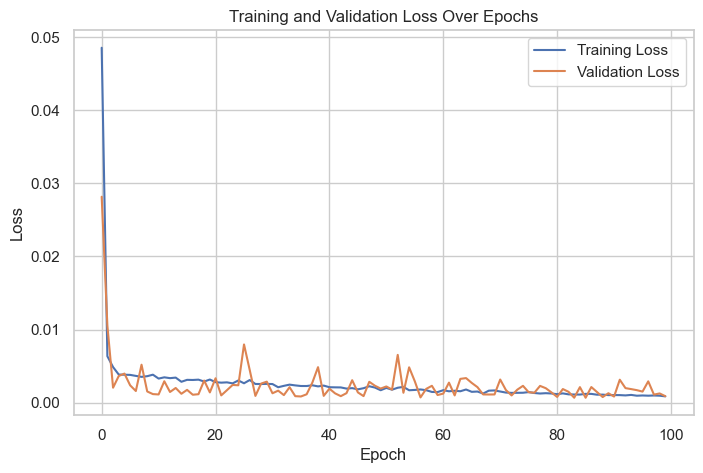

In [78]:
# Plot training loss and validation loss across epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 37ms/step


In [80]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [81]:
# Inverse transform the scaled target variables 'y_train' and 'y_test' using the 'scaler'
# This is done to revert the scaling and obtain the original values for better interpretation or evaluation
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [82]:
# Calculate train data RMSE
print('train data RMSE:',math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print('test data RMSE :', math.sqrt(mean_squared_error(y_test,test_predict)))

train data RMSE: 0.26531320988740764
test data RMSE : 0.378174485752755


In [83]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, test_predict)
Accuracy = 1 - MAPE

print('MAPE :',MAPE)
print('Accuracy :',Accuracy)

MAPE : 0.0205914673913395
Accuracy : 0.9794085326086605


In [84]:
from sklearn.metrics import r2_score


r2 = r2_score(y_train, train_predict)
print(f'R-squared train: {r2}')

r2 = r2_score(y_test, test_predict)
print(f'R-squared test: {r2}')

R-squared train: 0.9708142264038757
R-squared test: 0.7686335963223098


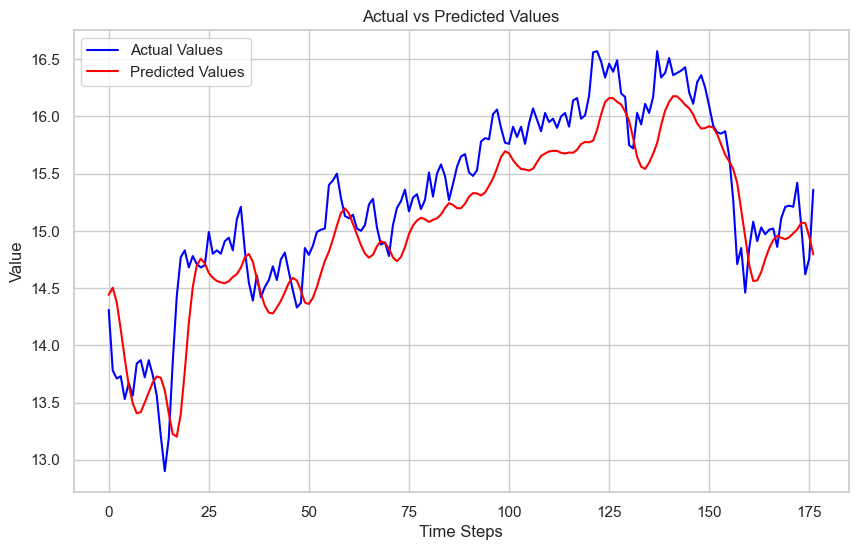

In [85]:
# Visualize the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(test_predict, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

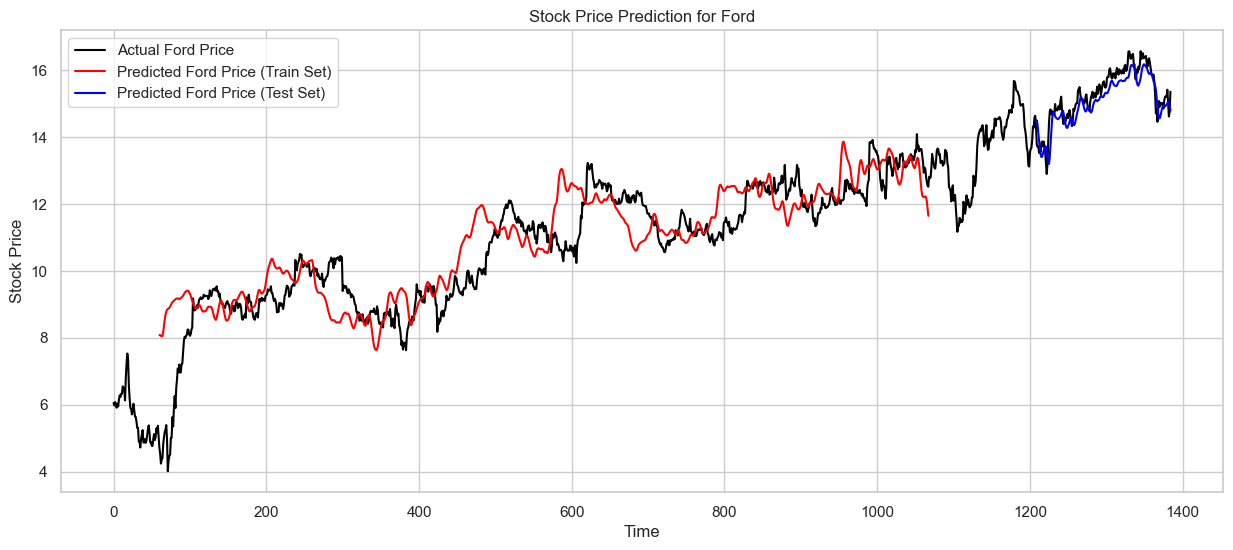

In [86]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(scaled_data) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label="Actual Ford Price")
plt.plot(trainPredictPlot, color='red', label="Predicted Ford Price (Train Set)")
plt.plot(testPredictPlot, color='blue', label="Predicted Ford Price (Test Set)")

plt.title("Stock Price Prediction for Ford")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

##  <u>Discussions and Conclusions</u>

**Model Configuration** | **Model 1: Default**                           | **Model 2: Hyperparameter Experimentation**  |
|------------------------|-----------------------------------------------|-----------------------------------------------|
| **Optimizer**           | Adam                                          | Adam                                          |
| **Learning Rate**       | Default                                       | Modified to 0.001                              |
| **Batch Size**          | 64                                            | Modified to 32                                 |
| **Epochs**              | 50                                            | Increased to 100                               |
| **Additional Layer**    | None                                          | Bidirectional LSTM layer introduced            |
| **Training Duration**   | 50 epochs, Batch size 64                       | 100 epochs, Batch size 32                      |

### 1. Settings and Models Tested:

Two LSTM models were tested for stock closing price prediction:

__Model 1:__

* Default hyperparameters and settings.
* Utilized the Adam optimizer.
* Trained for 50 epochs with a batch size of 64.
* No hyperparameter tuning.

__Model 2:__

* Hyperparameter tuning for optimization.
* Reduced learning rate to 0.001.
* Adjusted batch size to 32.
* Increased the number of epochs to 100.
* Introduced a bidirectional LSTM layer for capturing bidirectional dependencies.
* Utilized the Adam optimizer with the modified learning rate.
* Trained for 100 epochs with a batch size of 32.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2. Model Performance Comparision

| Metric           | Model 1           | Model 2           |
| ---------------- | ----------------- | ----------------- |
| Training RMSE    | 0.400             | 0.265             |
| Testing RMSE     | 0.435             | 0.378             |
| MAPE             | 0.0234            | 0.0206            |
| Accuracy         | 0.977             | 0.979             |
| R-squared (Train)| 0.934             | 0.971             |
| R-squared (Test) | 0.693             | 0.769             |
| Epochs           | 50                | 100               |


#### Comparative Analysis :

__RMSE:__

* Model 2 has lower RMSE values for both training and testing datasets compared to Model 1. Lower RMSE indicates better accuracy in predicting the stock closing prices.

__MAPE and Accuracy:__

* Model 2 shows a lower MAPE and a higher accuracy compared to Model 1. This suggests that, on average, the percentage difference between predicted and actual values is smaller in Model 2, leading to higher accuracy.

__R-squared:__

* Model 2 has higher R-squared values for both training and testing datasets. A higher R-squared value indicates that a larger proportion of the variance in the dependent variable is explained by the independent variables. Therefore, Model 2 is better at explaining the variability in the data.

__Epochs:__

* Model 2 was trained for more epochs (100) compared to Model 1 (50). This suggests that the longer training duration might have allowed Model 2 to learn more complex patterns in the data.

__Visual Inspection:__

* According to your visual inspection, Model 2's predicted values and patterns are more similar to the actual values than those of Model 1. This aligns with the quantitative metrics, indicating that Model 2 has a better overall performance.

### 3. Justification of The Best Model:

* Model 2 consistently outperformed Model 1 in terms of various performance metrics.

*  It has lower error metrics (RMSE, MAPE), higher accuracy, and better explanatory power (higher R-squared values) on both training and testing datasets. The visual inspection further supports the quantitative results, indicating that Model 2 captures the underlying patterns in the data more effectively.

<u>Therefore, Model 2 is justified as the best model due to its lower error metrics, higher accuracy, and better ability to explain the variance in the data. The hyperparameter adjustments and additional layers in Model 2 contributed to its improved performance.</u>



### 4. Main Observations and Learning Points:

1. __Hyperparameter Tuning Matters:__ Adjusting hyperparameters can significantly impact model performance. Model 2's success demonstrates the importance of experimenting with learning rates, batch sizes, and model complexity.

2. __Model Complexity and Training Duration:__ Increasing the number of epochs allowed Model 2 to learn more complex patterns. However, careful monitoring is essential to avoid overfitting.

3. __Visual Inspection:__ Visualizing model predictions against actual values is a valuable step for qualitative assessment and model selection.


### 5. Strengths and Weaknesses:

__Strengths:__

* Model 2 exhibited improved accuracy and predictive power.
* Hyperparameter tuning and architectural changes positively influenced the model's performance.

__Weaknesses:__

* Overfitting risk: While Model 2 performs well on the testing set, it's crucial to monitor for potential overfitting, especially with an increased number of epochs.
* The comparison is limited to two models; exploring a broader range of architectures and hyperparameters could provide further insights.


### 6. Improvements for the Future:

__1. Ensemble Methods:__

* Explore the use of ensemble methods, such as bagging or boosting, to combine predictions from multiple models. This can enhance the overall predictive performance and provide more robust results.

__2. Feature Engineering:__

* Consider incorporating additional relevant features or performing feature engineering to capture more nuanced information from the data. This could involve extracting time-based features, technical indicators, or sentiment analysis from external sources.

__3. Regularization Techniques:__

* Implement advanced regularization techniques, such as L2 regularization, to prevent overfitting. Regularization helps to control the complexity of the model and improve its generalization to unseen data.

__4. Cross-Validation:__

* Utilize cross-validation techniques to assess the model's performance across multiple data splits. This helps ensure that the model's performance is consistent and reliable on different subsets of the data.

__5. Incorporate External Factors:__

* Consider integrating external factors that may influence stock prices, such as news sentiment, economic indicators, or geopolitical events. Incorporating these factors into the model can provide a more comprehensive understanding of the underlying dynamics affecting stock prices.


### 7. Conclusion

In conclusion, the experimentation and analysis showcase the impact of thoughtful hyperparameter tuning and model architecture adjustments on LSTM model performance. The adjustments made to hyperparameters, such as the learning rate, batch size, and number of epochs, have contributed to the improved performance of Model 2. This highlights the importance of hyperparameter tuning in optimizing the performance of neural network models.

However still there's room for further refinement, and with the continuous experimentation we can make even more accurate predictive models.